# RAPIDS KNN and KMeans - [0.600]
In this notebook, we will use [RAPIDS][1] Nearest Neighbors and [RAPIDS][1] KMeans to help us understand the data. We will find similar `u_in` time series and display them. We will notice that many time series with the same `u_in` have different `pressure`! This will help us to understand how parameters `R` and `C` affect `pressure` when the same `u_in` is used for different `R` and `C` combinations. 

We will also notice that many `u_in` time series patterns appear often in the dataset. We will train RAPIDS KNN on train and infer test and submit to Kaggle. The CV MAE score is 0.600, what will the LB score be?

[1]: https://rapids.ai/start.html

In [1]:
# LOAD LIBRARIES
import pandas as pd, numpy as np
import cudf, cupy
import matplotlib.pyplot as plt
print('RAPIDS version',cudf.__version__)

ModuleNotFoundError: No module named 'cudf'

# Load Train
First we will load train dataset with RAPIDS cudf. Then we will convert the train dataset into dataframe with each row as 80 step time series

In [2]:
# LOAD TRAIN
train = cudf.read_csv('../input/ventilator-pressure-prediction/train.csv')
exhale = 80-train.groupby('breath_id')[['u_out']].agg('sum')
length = train.groupby('breath_id')[['time_step']].agg('max')
print('Train shape:',train.shape)
train.head()

Train shape: (6036000, 8)


id  breath_id   R   C  time_step       u_in  u_out   pressure
0   1          1  20  50   0.000000   0.083334      0   5.837492
1   2          1  20  50   0.033652  18.383041      0   5.907794
2   3          1  20  50   0.067514  22.509278      0   7.876254
3   4          1  20  50   0.101542  22.808822      0  11.742872
4   5          1  20  50   0.135756  25.355850      0  12.234987

In [3]:
# CONVERT TRAIN TO SERIES
series = train.groupby('breath_id').collect().reset_index()
for k in range(80): series[f'x_{k}'] = series.u_in.list.get(k)
for k in range(80): series[f'y_{k}'] = series.pressure.list.get(k)
for k in range(80): series[f'z_{k}'] = 1-series.u_out.list.get(k)
series.R = series.R.list.get(0)
series.C = series.C.list.get(0)
series = series.drop(['id','time_step','u_in','u_out','pressure'],axis=1)
series = series.merge(exhale,on='breath_id',how='left')
series = series.merge(length,on='breath_id',how='left')
series = series.rename({'time_step':'time_length','u_out':'expire'},axis=1)
series = series.sort_values('breath_id').reset_index(drop=True)

print('Train as series shape:', series.shape )
print('Min inhale length=', series['expire'].min(),',Max inhale length=', series['expire'].max(),
      'Max breath length=',series['time_length'].max() )
series.head()

Train as series shape: (75450, 245)
Min inhale length= 25 ,Max inhale length= 32 Max breath length= 2.937237977981568


breath_id   R   C        x_0        x_1        x_2        x_3        x_4  \
0          1  20  50   0.083334  18.383041  22.509278  22.808822  25.355850   
1          2  20  20  12.184338  13.980205  12.574163  11.730537  12.124229   
2          3  50  20   0.000000   7.187242  13.338781  17.111335  18.353980   
3          4  50  50   0.000000   1.262539   4.001352   6.379411   8.295194   
4          5   5  50  21.424375  28.504653  29.353025  30.502095  31.024647   

         x_5        x_6  ...  z_72  z_73  z_74  z_75  z_76  z_77  z_78  z_79  \
0  27.259866  27.127486  ...     0     0     0     0     0     0     0     0   
1  11.055636  10.774428  ...     0     0     0     0     0     0     0     0   
2  17.417672  15.353111  ...     0     0     0     0     0     0     0     0   
3   9.790410  10.874443  ...     0     0     0     0     0     0     0     0   
4  32.224651  32.364788  ...     0     0     0     0     0     0     0     0   

   expire  time_length  
0      30     2.689766  
1      29     2.690624  
2      32     2.525398  
3      32     2.528579  
4      29     2.724876  

[5 rows x 245 columns]

# Display Similar Time Series with RAPIDS KNN
Using RAPIDS KNN, we can find time series of `u_in` that are similar to a specific time series `u_in`. This allows us to understand variables `R` and `C` better by keeeping `u_in` the same and watching how `R` and `C` affect `pressure`. We will plot 300 similar time series to a given `u_in` time series. We will also plot each series' `pressure`. We will color the pressures based on their `R` and `C` values.

In the first plots below (`breath_id=28`), we observe how the variable `C` controls how `pressure` increases when inputting constant `u_in`. In the second plot below (`breath_id=87`), we observe how the variable `R` controls how `pressure` increases when inputting a strong spike of `u_in`. In the third plot below (`breath_id=101`), we observe how the variable `C` dampens (flattens) an input of oscillating `u_in`.

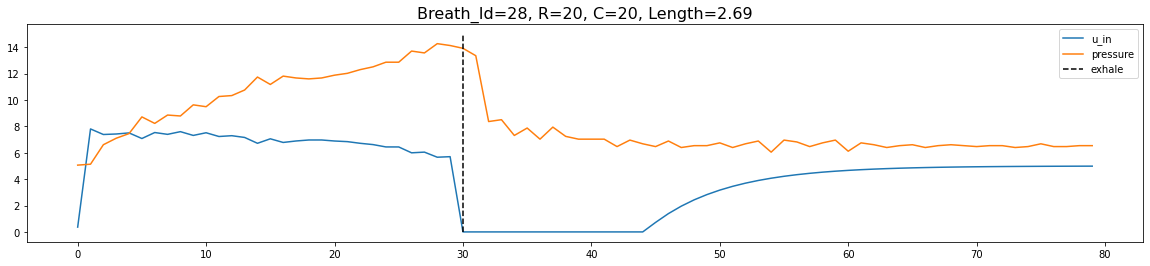

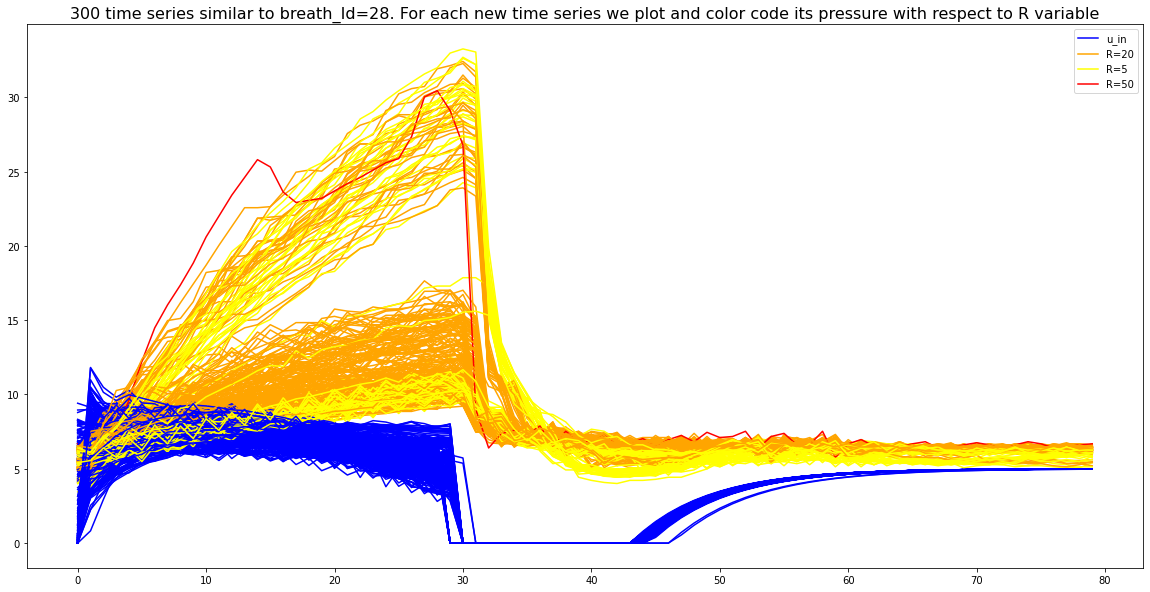

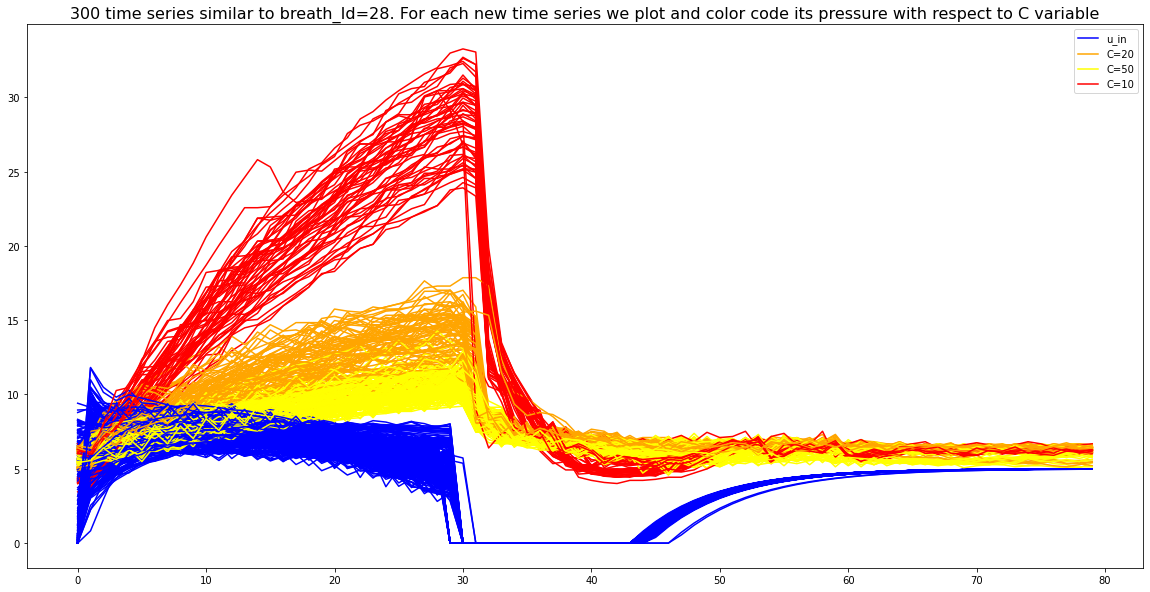

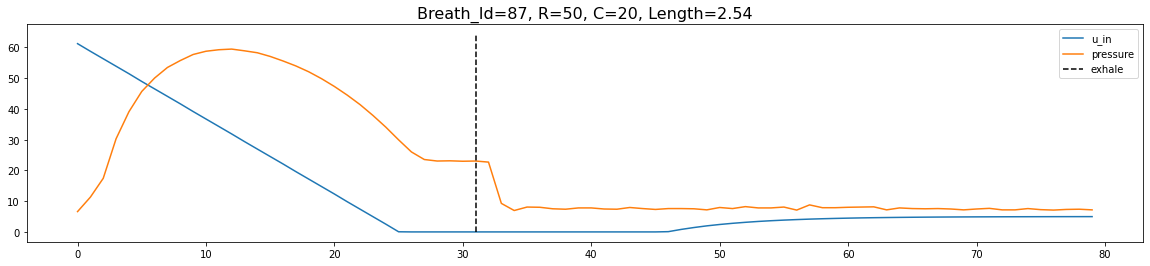

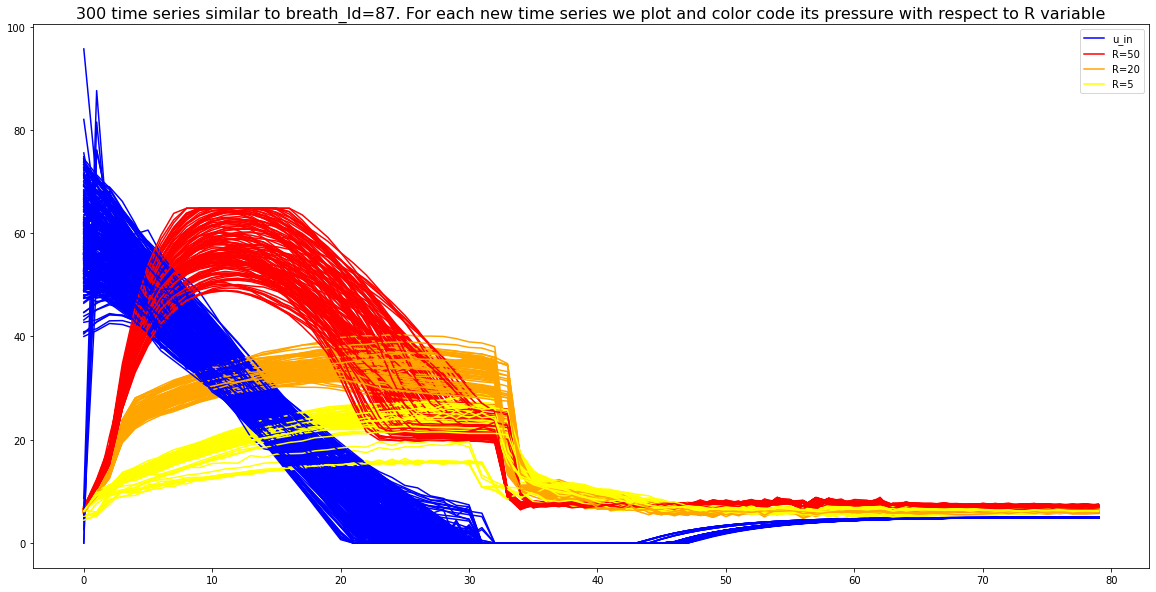

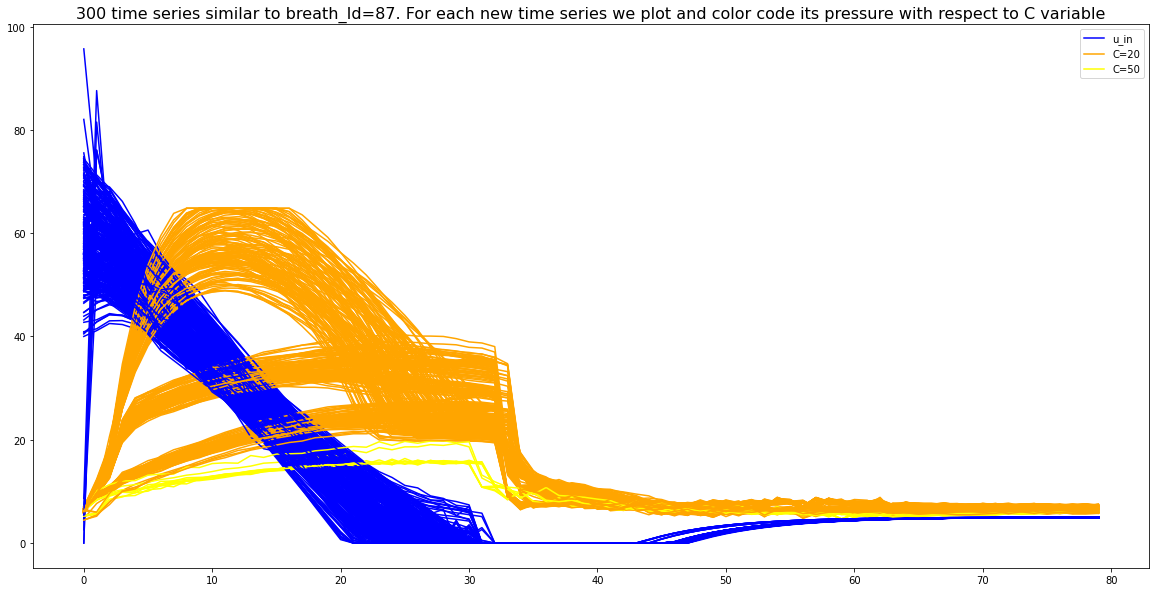

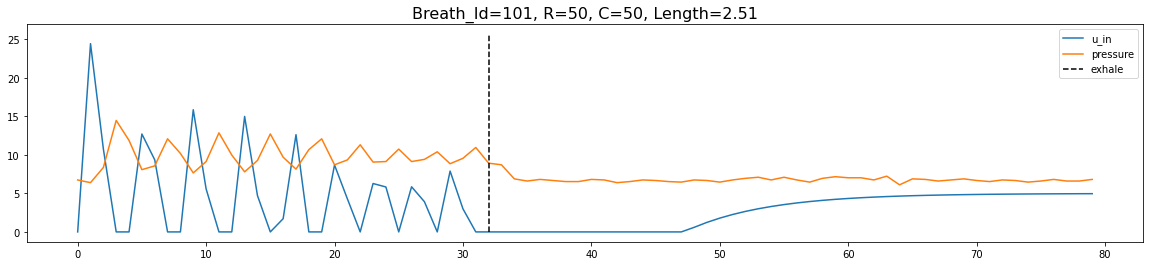

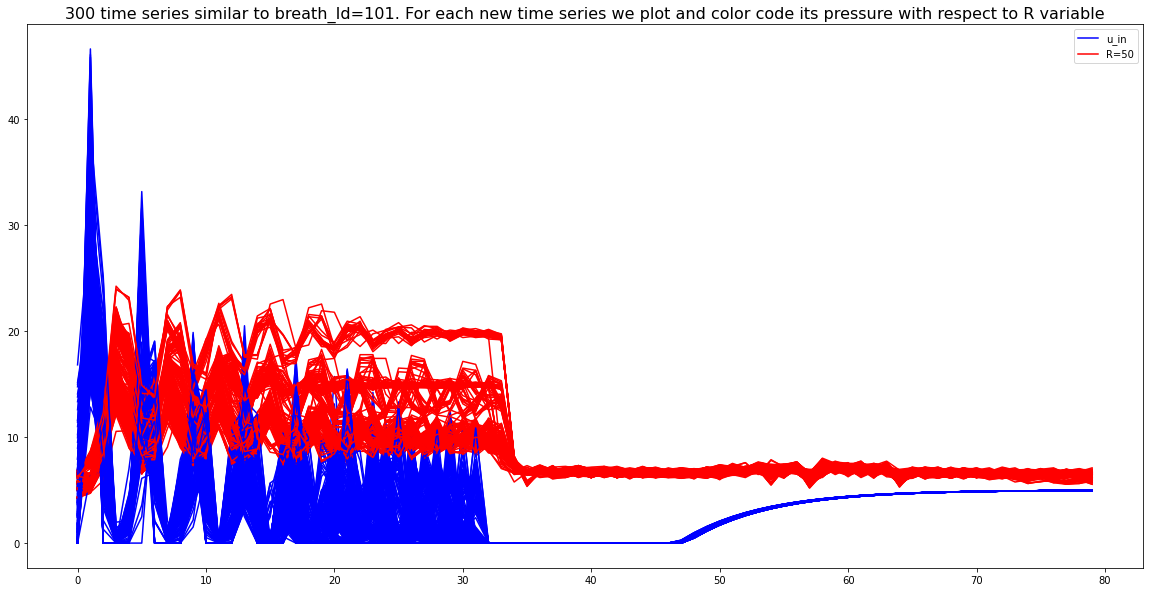

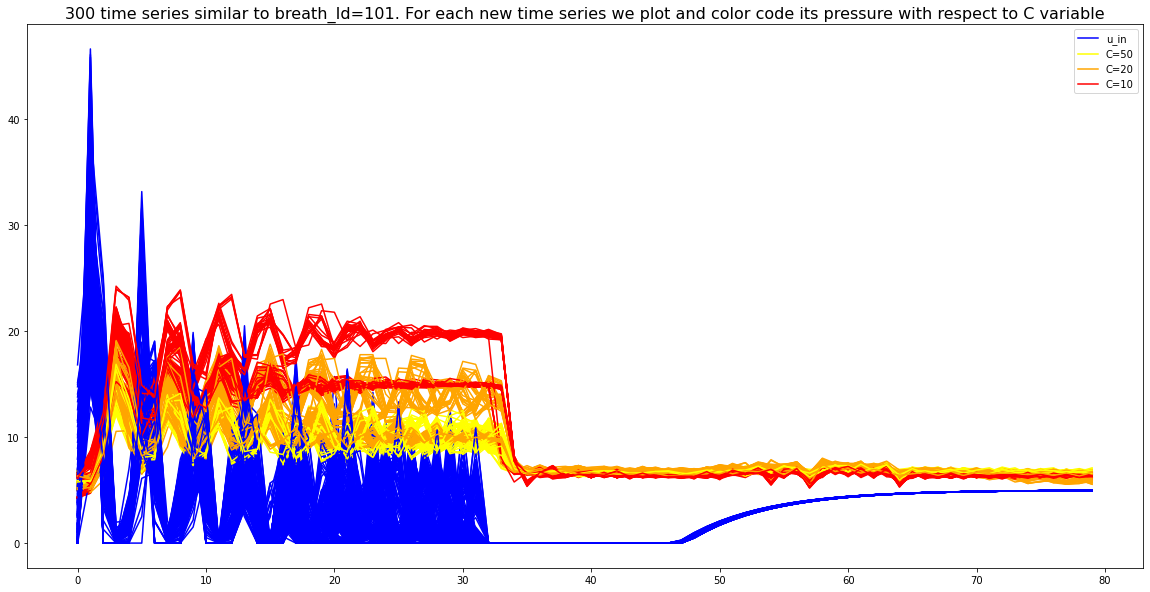

In [4]:
from cuml.neighbors import NearestNeighbors 

# FIRST 3 COLUMNS OF TRAIN SERIES DATAFRAME NEED TO BE IGNORED
IGNORE = 3
# MORE NEIGHBORS THAN WE NEED FOR ALL DISPLAYS
NEIGHBORS = 500
# HOW MANY TIME_STEPS TO USE FOR KNN COMPARISON
TIME_STEPS = 80
# HOW MANY INITIAL TIME_STEPS TO SKIP FOR KNN COMPARISON
SKIP = 0 

model = NearestNeighbors(n_neighbors=NEIGHBORS, metric='l1')
model.fit(series.iloc[:,IGNORE+SKIP:IGNORE+TIME_STEPS+SKIP])

SHOW = [24,68,75]
CTS = [300]*len(SHOW)

for USE,CT in zip(SHOW,CTS):
    distances, indices = model.kneighbors(series.iloc[USE:USE+1,IGNORE+SKIP:IGNORE+TIME_STEPS+SKIP])
        
    plt.figure(figsize=(20,4))
    plt.plot(np.arange(80),series.iloc[USE,IGNORE:IGNORE+80].to_array(),label='u_in')
    plt.plot(np.arange(80),series.iloc[USE,IGNORE+80:IGNORE+160].to_array(),label='pressure')
    y_max = plt.ylim()[1]
    if TIME_STEPS!=80: plt.plot([SKIP+TIME_STEPS-1,SKIP+TIME_STEPS-1],[0,y_max],'--',color='gray')
    if SKIP!=0: plt.plot([SKIP-1,SKIP-1],[0,y_max],'--',color='gray')
    exhale = series.loc[USE,'expire']
    plt.plot([exhale,exhale],[0,y_max],'--',color='black',label='exhale')
    rr = series.loc[USE,'R']; cc = series.loc[USE,'C']; 
    bb = series.loc[USE,'breath_id']; tt = series.loc[USE,'time_length']
    plt.title(f'Breath_Id={bb}, R={rr}, C={cc}, Length={tt:.3}',size=16)
    plt.legend()
    
    temp2 = series.iloc[indices.iloc[0].values].reset_index(drop=True)
    cdict = {5: 'yellow', 20: 'orange', 50: 'red'}
    plt.figure(figsize=(20,10))
    legend = {5:0, 20:0, 50:0}
    for r in range(CT):
        if r==0: plt.plot(np.arange(80), temp2.iloc[r,IGNORE:IGNORE+80].to_array(), color='blue', label='u_in')
        else: plt.plot(np.arange(80), temp2.iloc[r,IGNORE:IGNORE+80].to_array(), color='blue')
        if legend[temp2.loc[r,'R']]==0:
            legend[temp2.loc[r,'R']]=1; cc = temp2.loc[r,'R']
            plt.plot(np.arange(80), temp2.iloc[r,IGNORE+80:IGNORE+160].to_array(), 
                     c=cdict[temp2.loc[r,'R']], label=f'R={cc}')
        else: plt.plot(np.arange(80), temp2.iloc[r,IGNORE+80:IGNORE+160].to_array(), c=cdict[temp2.loc[r,'R']])
    y_max = plt.ylim()[1]
    if TIME_STEPS!=80: plt.plot([SKIP+TIME_STEPS-1,SKIP+TIME_STEPS-1],[0,y_max],'--',color='gray')
    if SKIP!=0: plt.plot([SKIP-1,SKIP-1],[0,y_max],'--',color='gray')
    plt.title(f'{CT} time series similar to breath_Id={bb}. For each new time series we plot and color code its pressure with respect to R variable',size=16)
    plt.legend()
    plt.show()
    
    temp2 = series.iloc[indices.iloc[0].values].reset_index(drop=True)
    cdict = {10: 'red', 20: 'orange', 50: 'yellow'}
    plt.figure(figsize=(20,10))
    legend = {10:0, 20:0, 50:0}
    for r in range(CT):
        if r==0: plt.plot(np.arange(80), temp2.iloc[r,IGNORE:IGNORE+80].to_array(), color='blue',label='u_in')
        else: plt.plot(np.arange(80), temp2.iloc[r,IGNORE:IGNORE+80].to_array(), color='blue')
        if legend[temp2.loc[r,'C']]==0:
            legend[temp2.loc[r,'C']]=1; cc = temp2.loc[r,'C']
            plt.plot(np.arange(80), temp2.iloc[r,IGNORE+80:IGNORE+160].to_array(), 
                     c=cdict[temp2.loc[r,'C']], label=f'C={cc}')
        else: plt.plot(np.arange(80), temp2.iloc[r,IGNORE+80:IGNORE+160].to_array(), c=cdict[temp2.loc[r,'C']])
    y_max = plt.ylim()[1]
    if TIME_STEPS!=80: plt.plot([SKIP+TIME_STEPS-1,SKIP+TIME_STEPS-1],[0,y_max],'--',color='gray')
    if SKIP!=0: plt.plot([SKIP-1,SKIP-1],[0,y_max],'--',color='gray')
    plt.title(f'{CT} time series similar to breath_Id={bb}. For each new time series we plot and color code its pressure with respect to C variable',size=16)
    plt.legend()
    plt.show()

# Display Similar Time Series with RAPIDS KMeans Clustering
Below we use RAPIDS KMeans clustering to find different patten types of `u_in` time series. The first 16 displayed have `pressure` color coded from `C` variable. And the second 16 have `pressure` color coded from `R` variable. We notice there are a large variety of `u_in` patterns. We notice that each pattern occurs often in the competition data. Lastly we observe how variables `R` and `C` affect `pressure`.

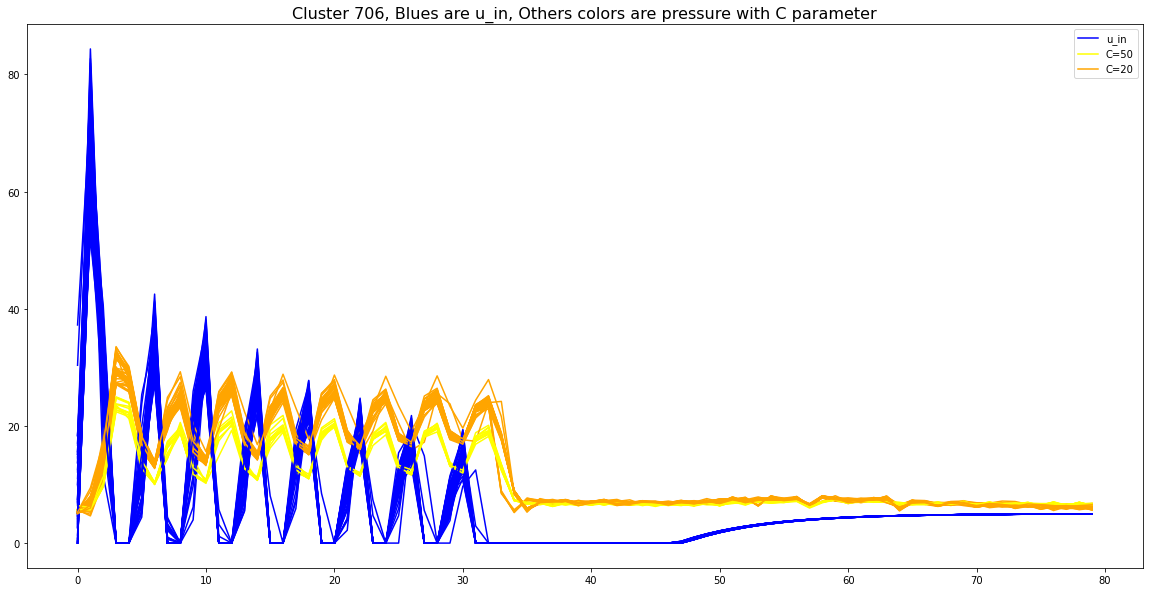

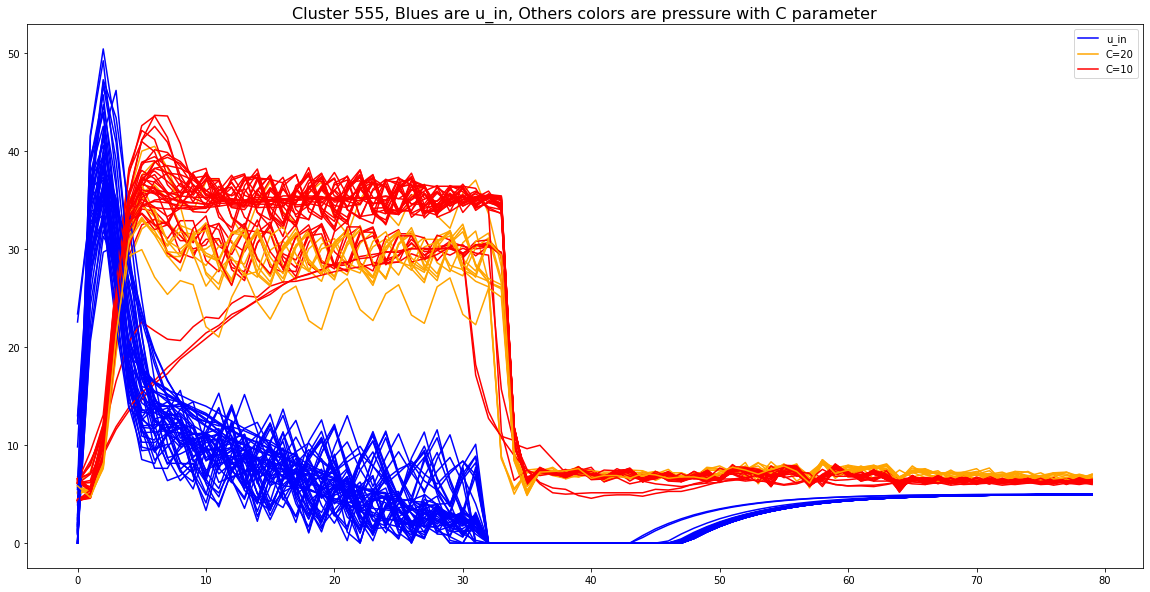

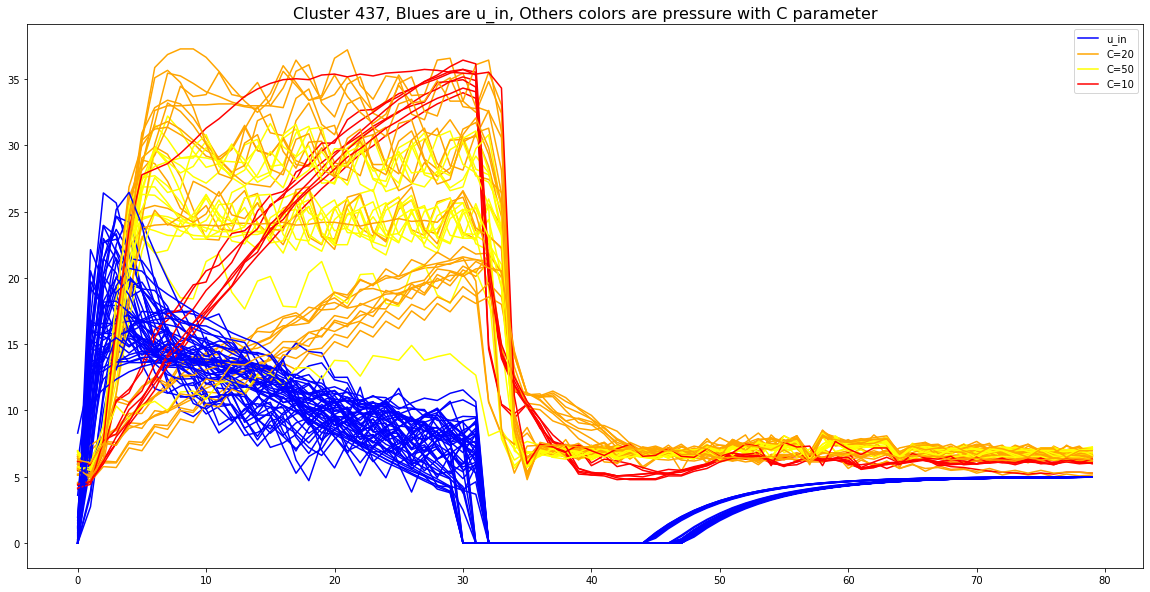

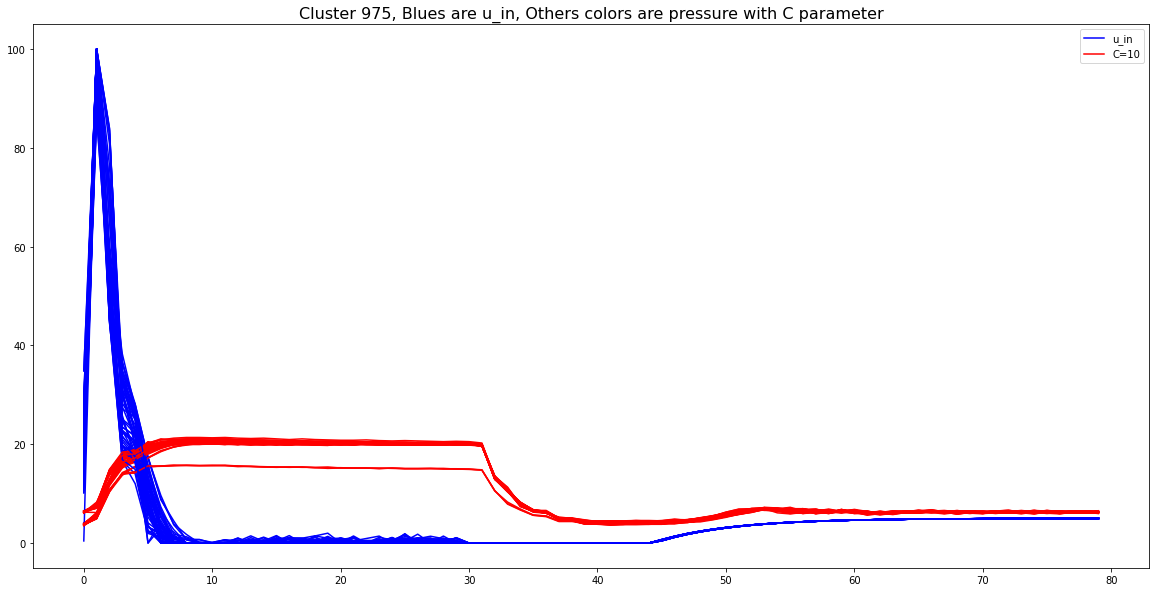

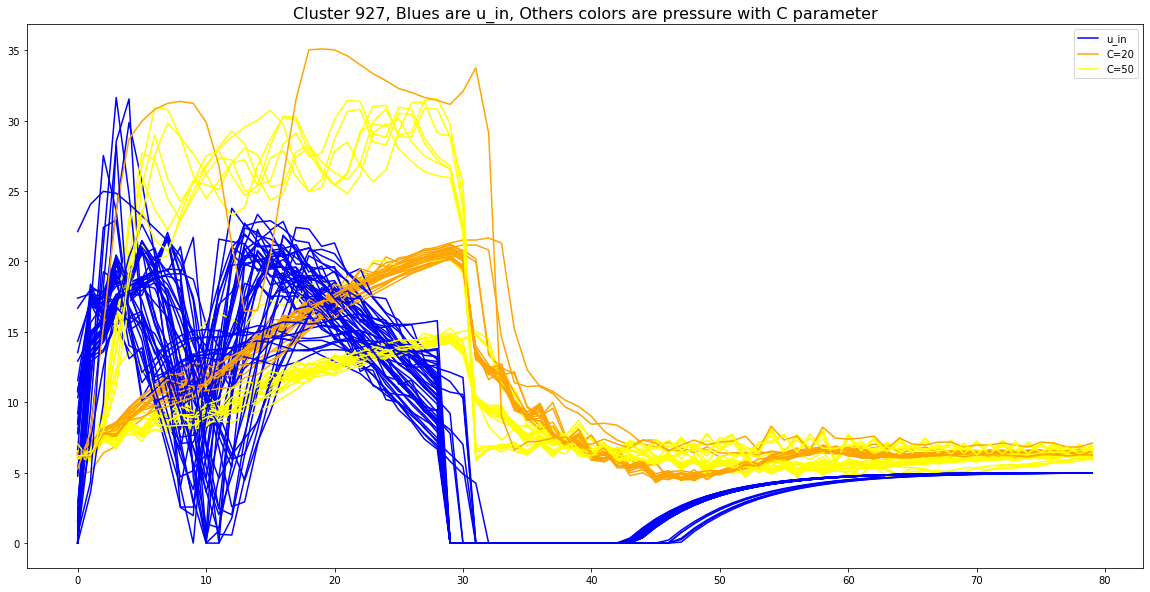

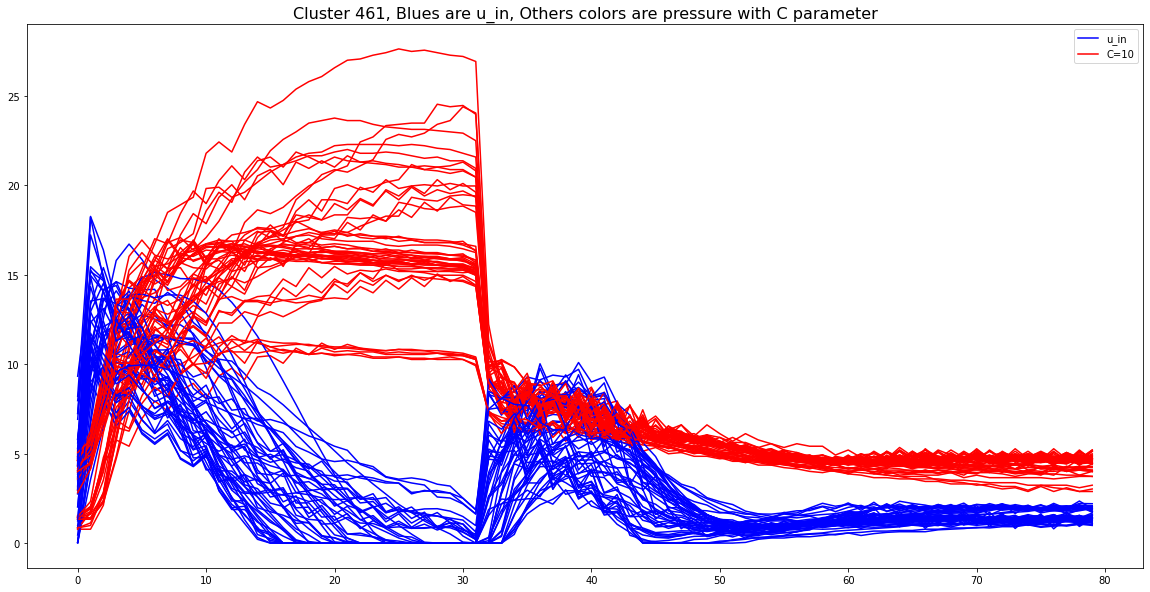

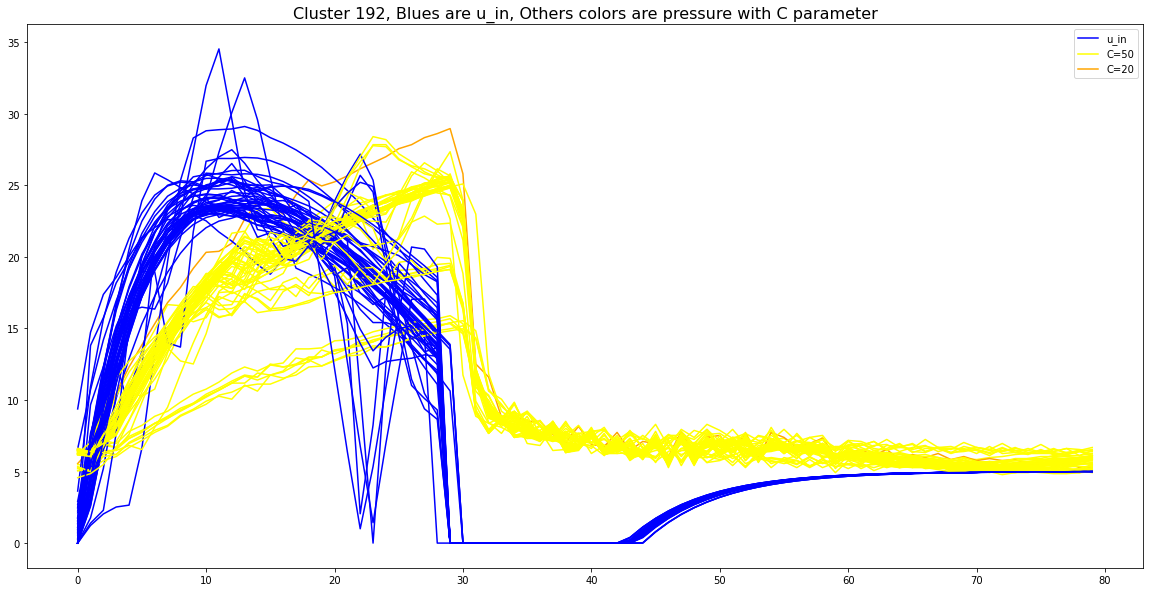

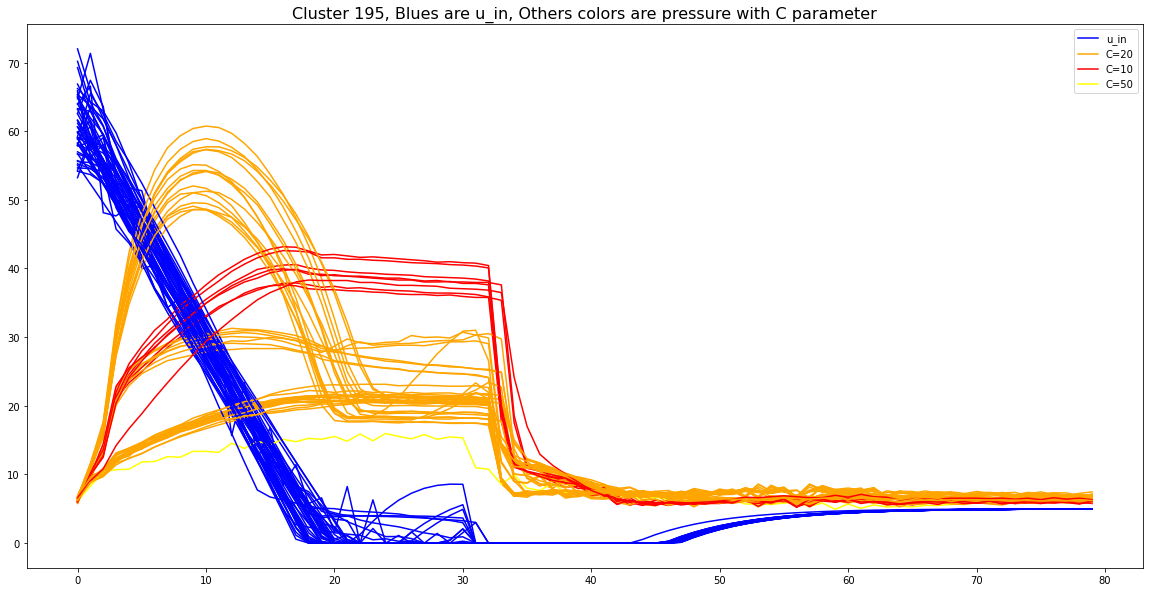

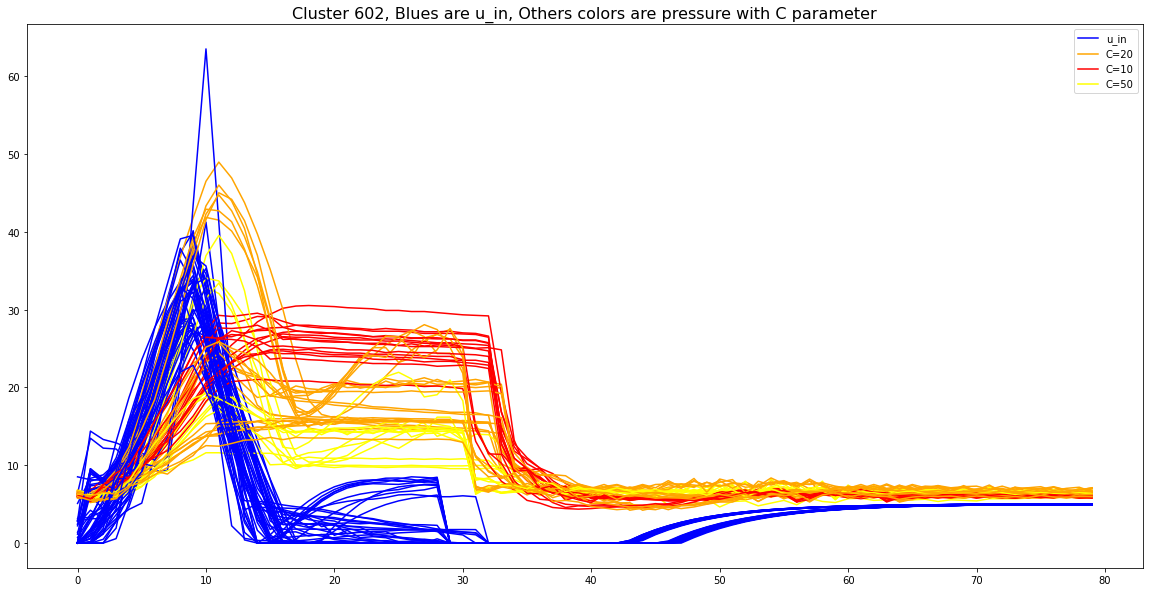

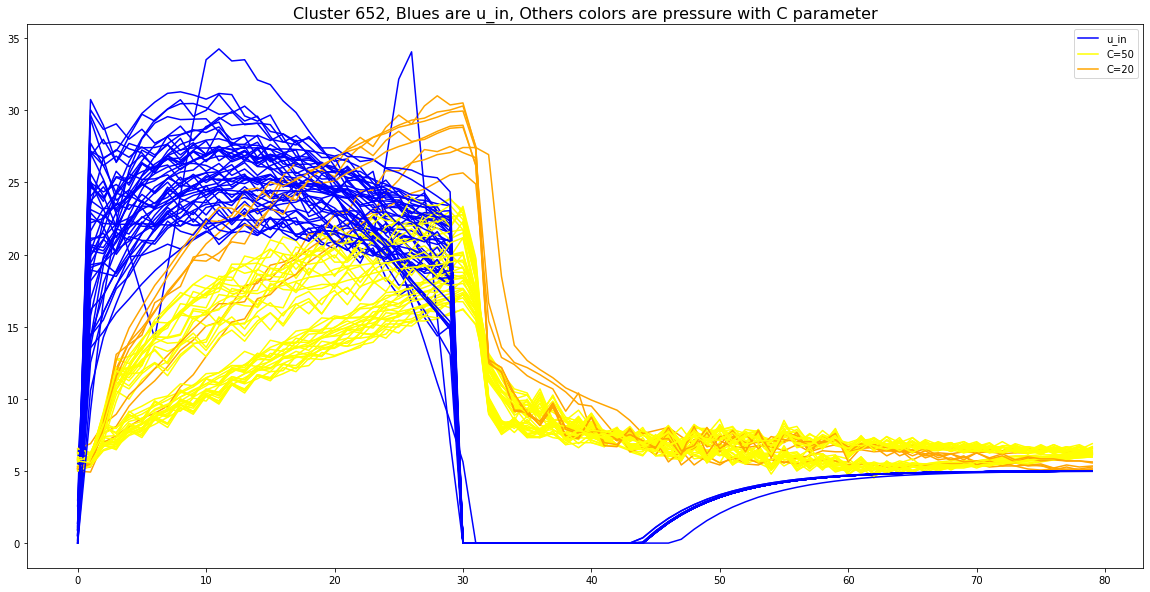

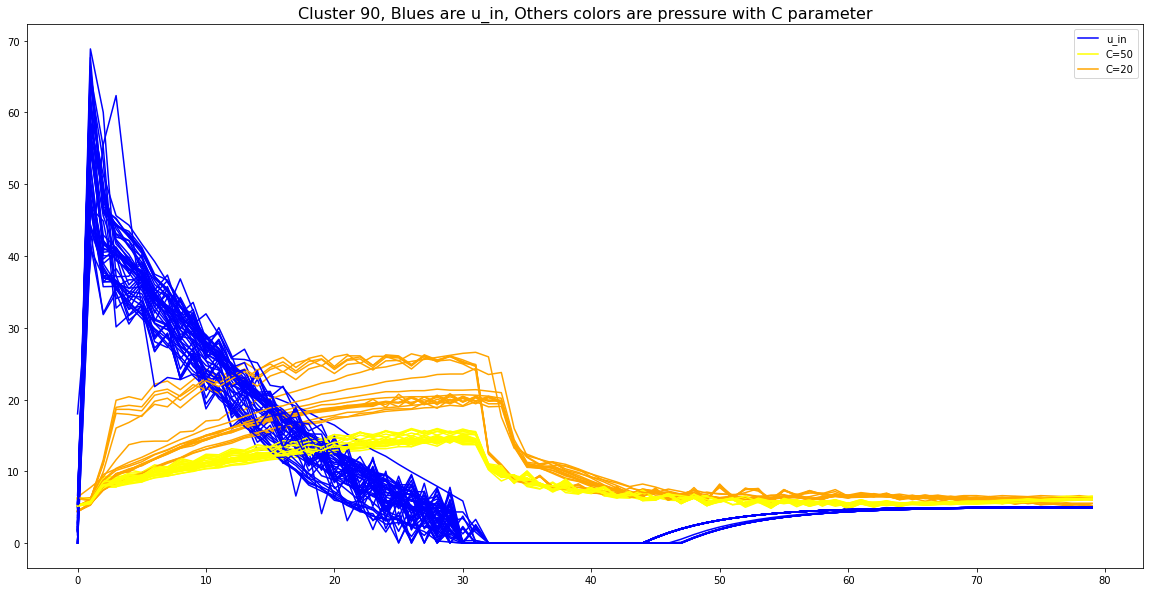

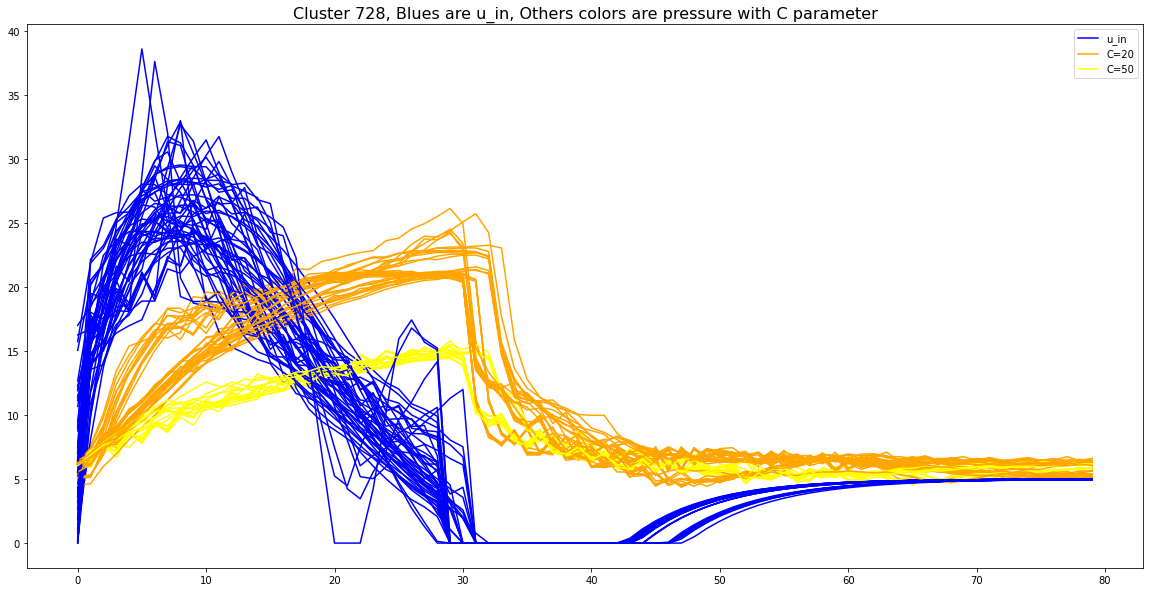

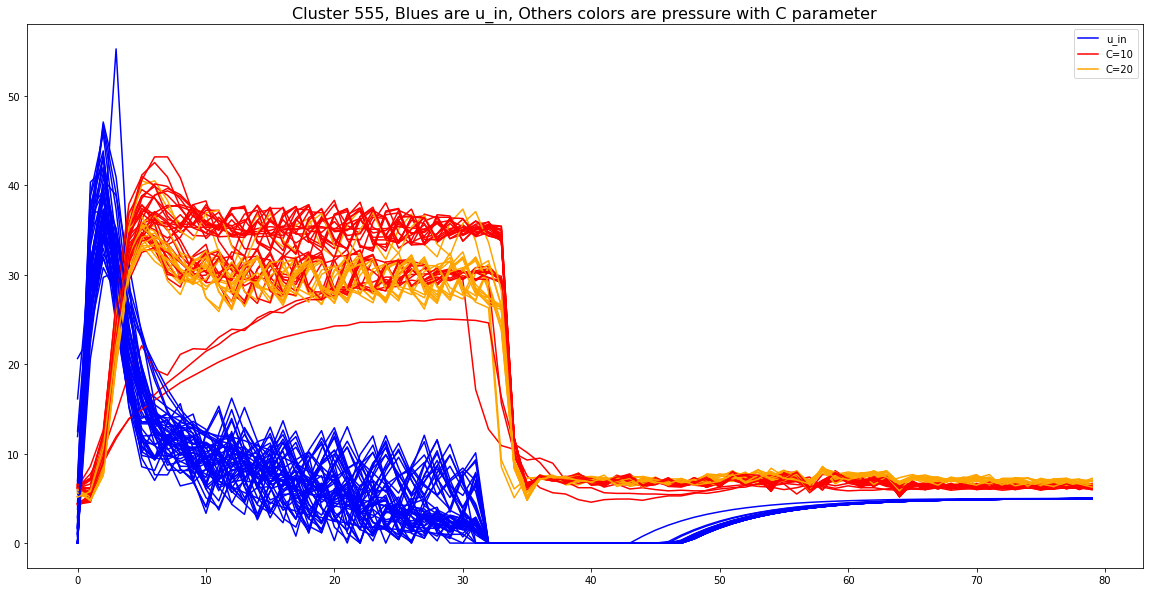

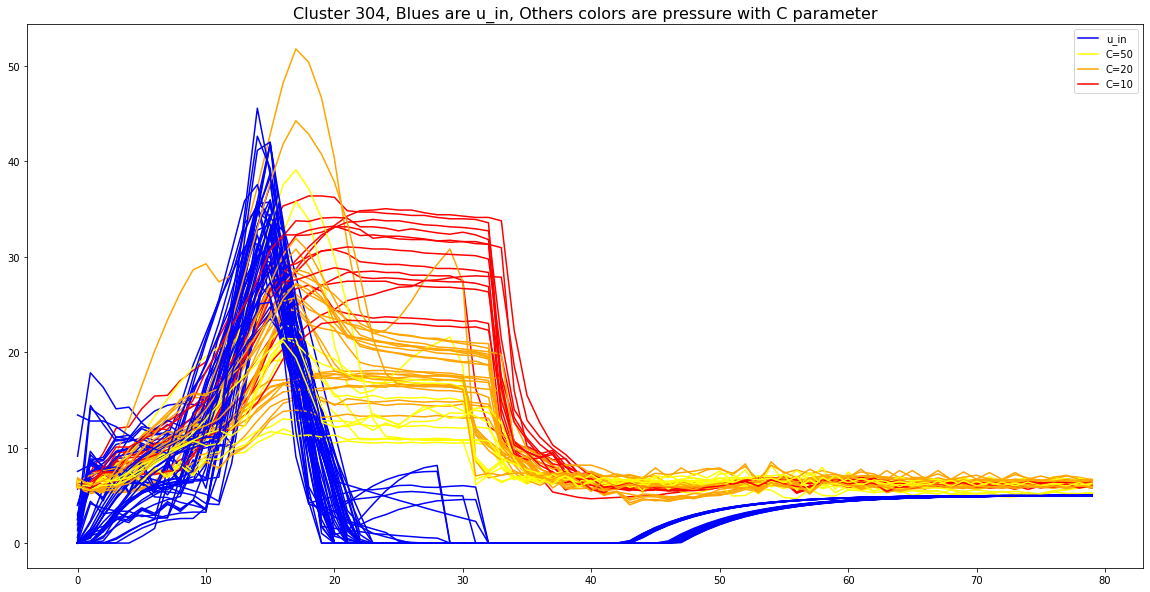

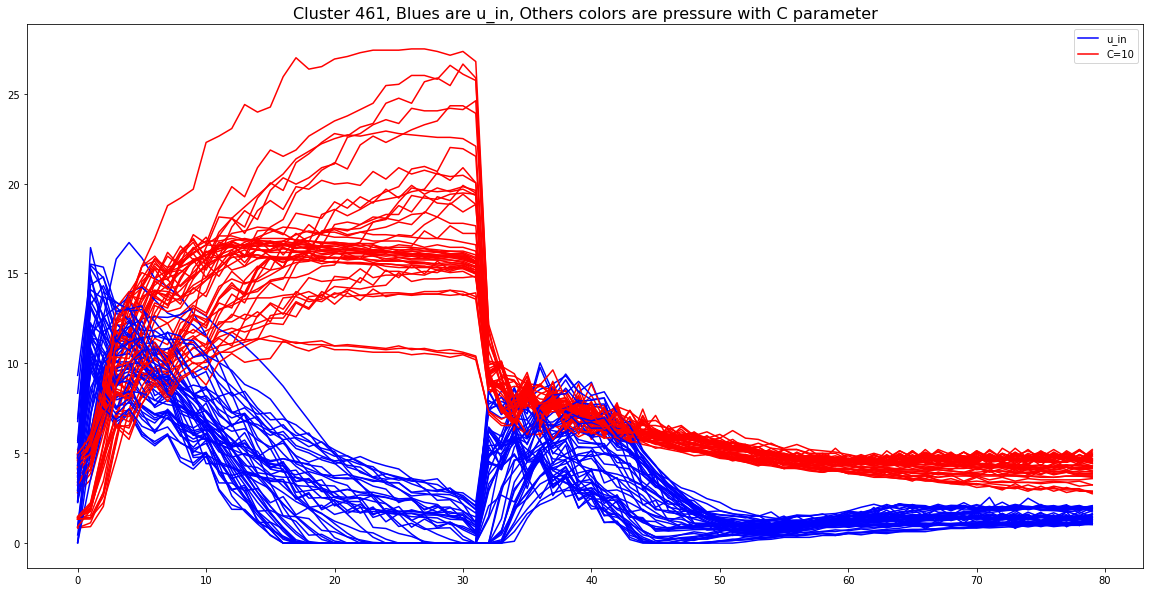

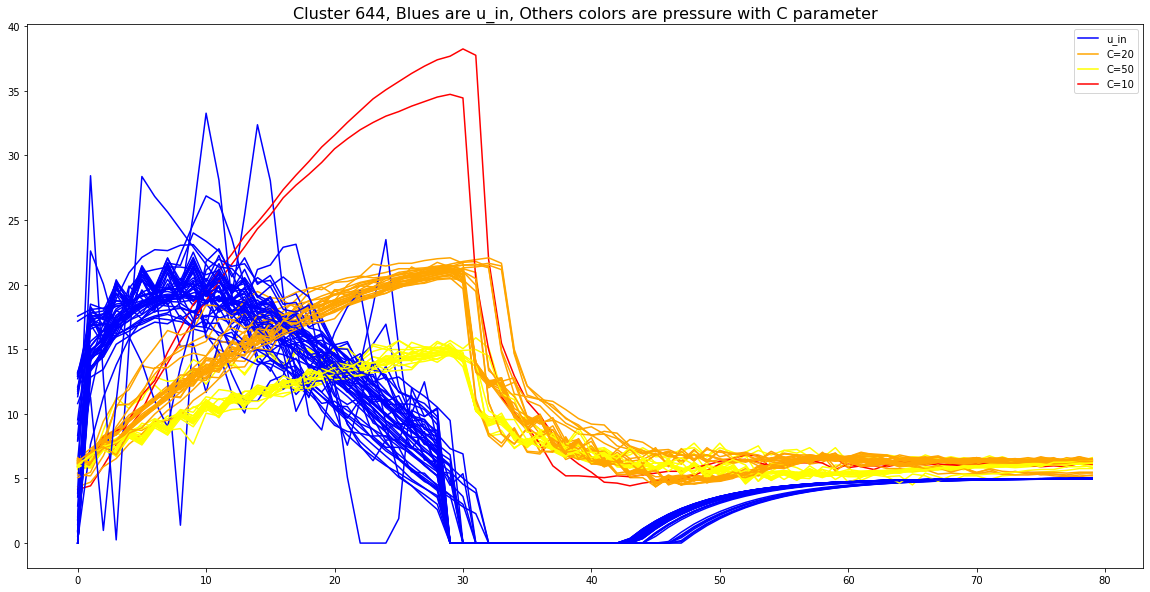

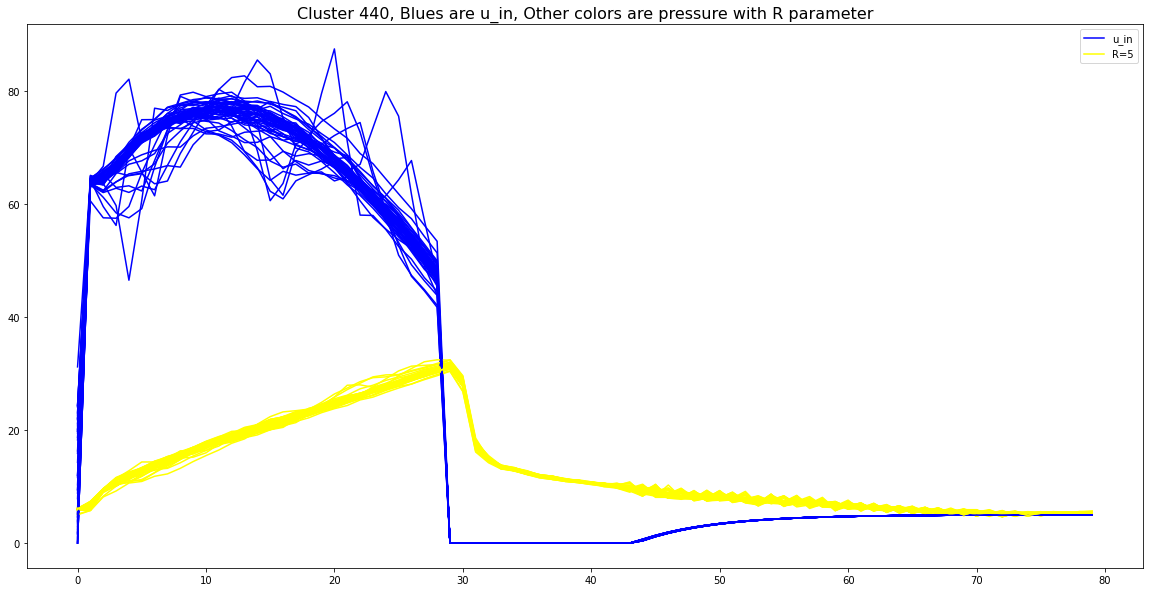

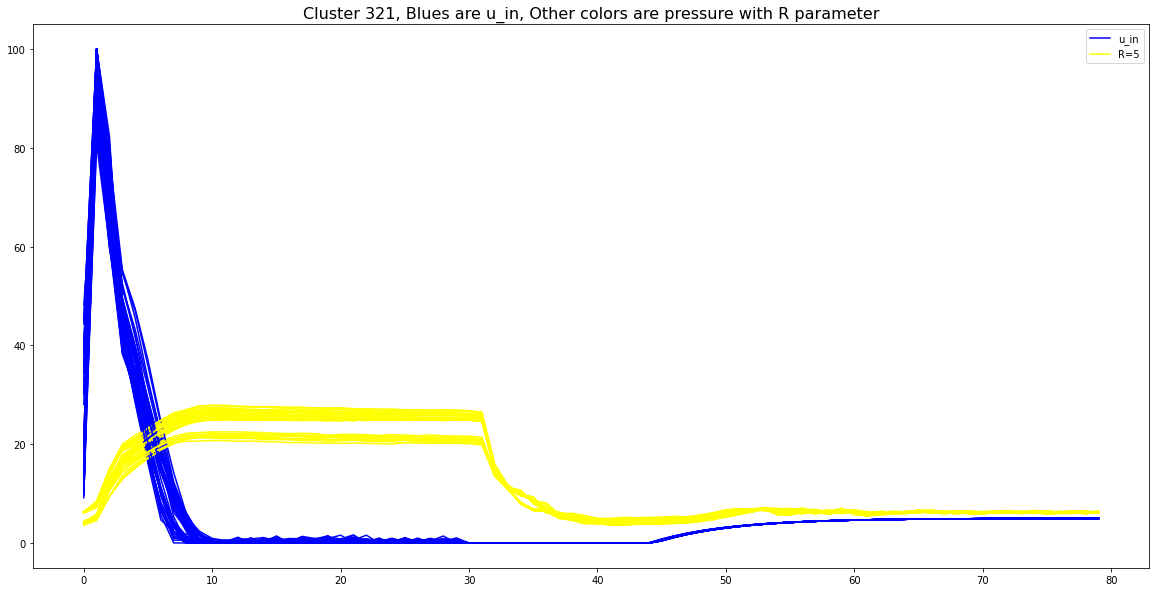

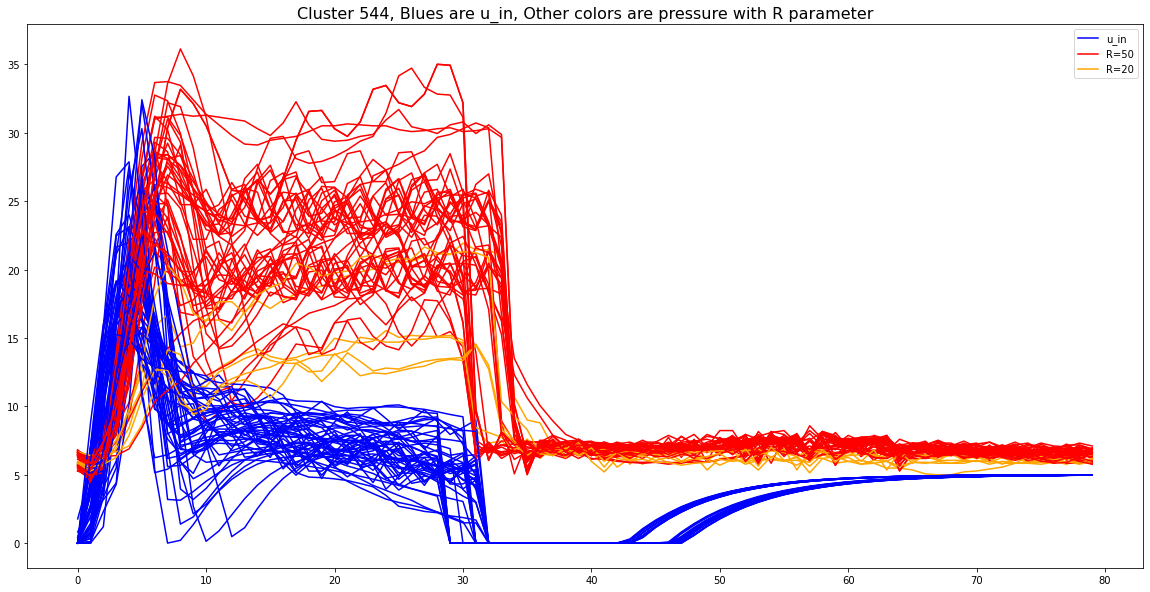

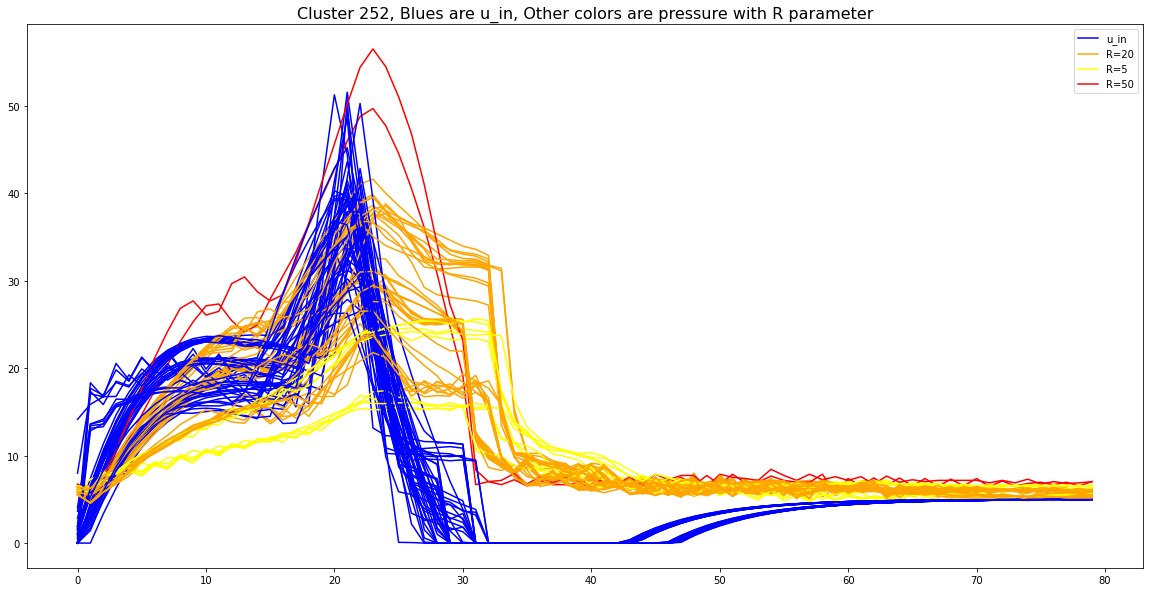

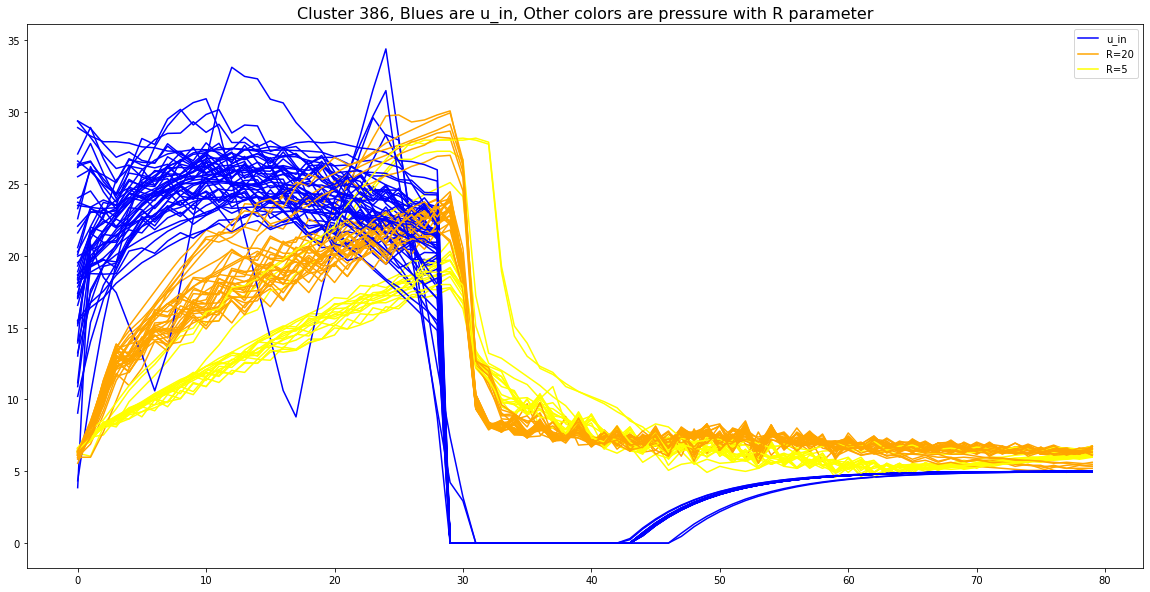

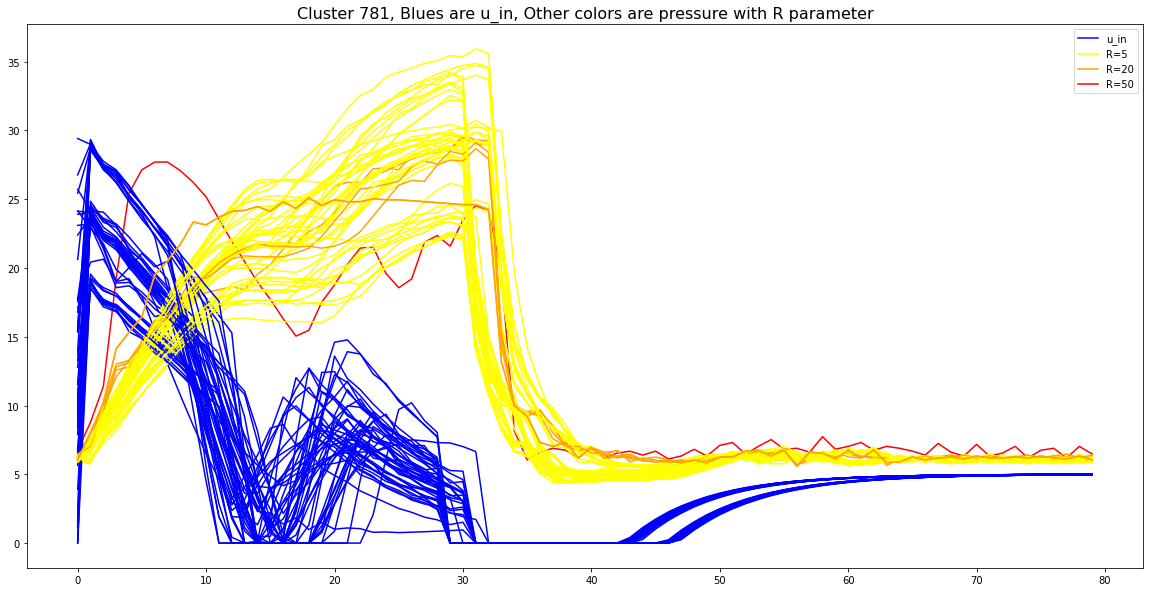

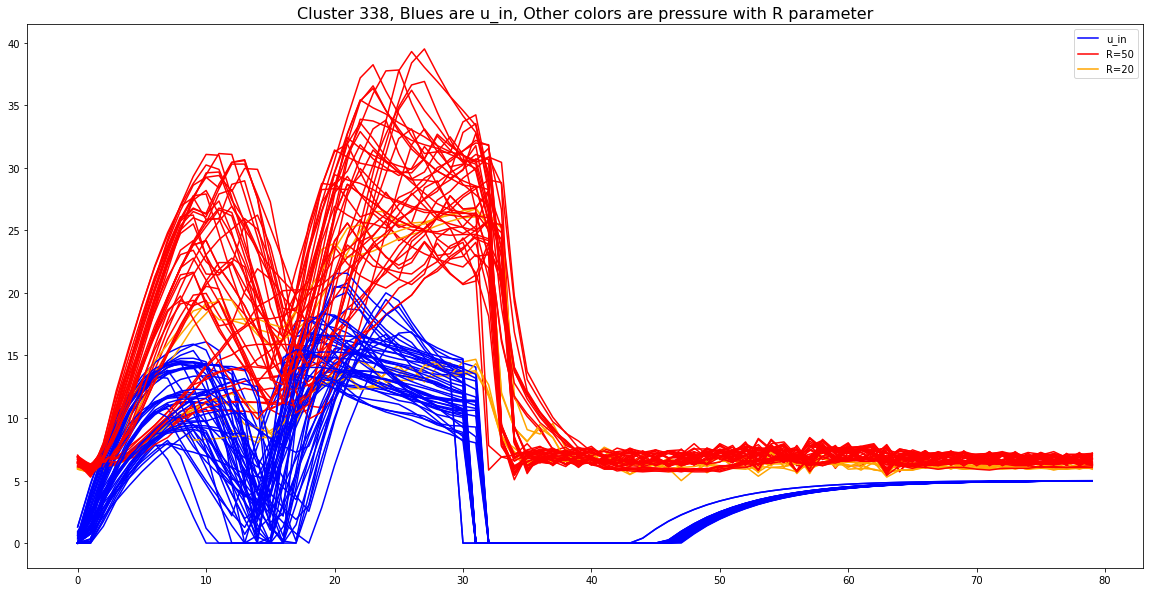

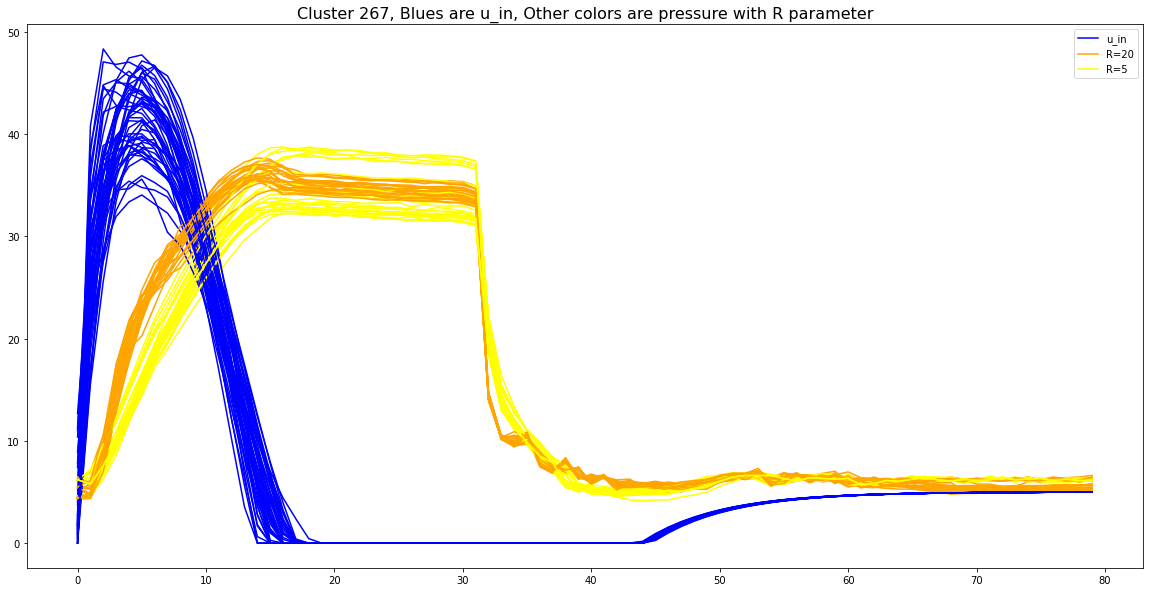

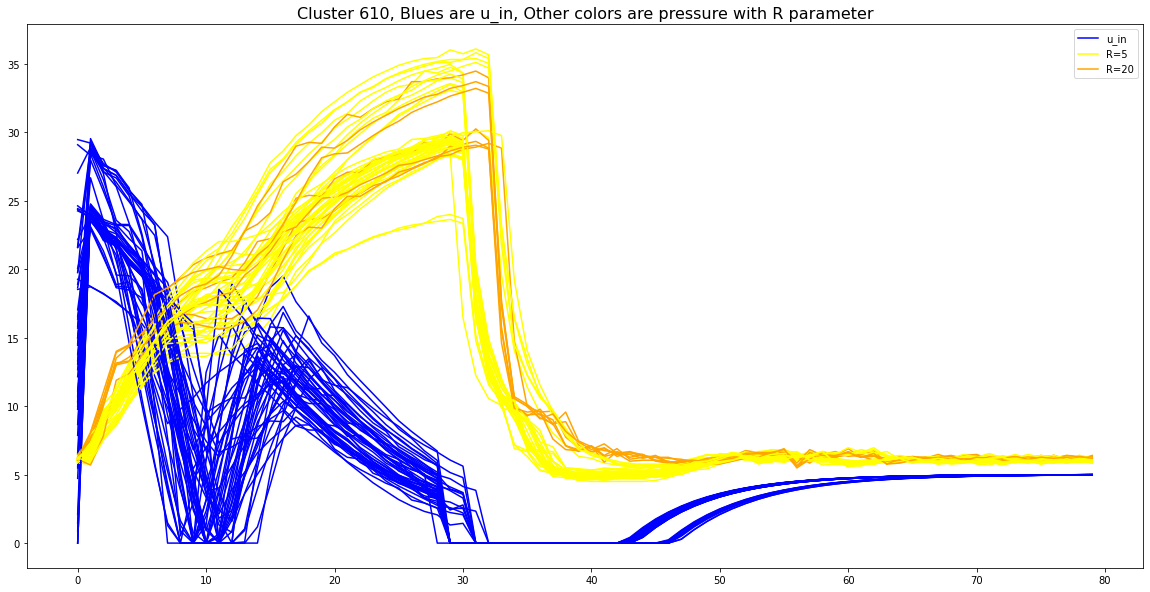

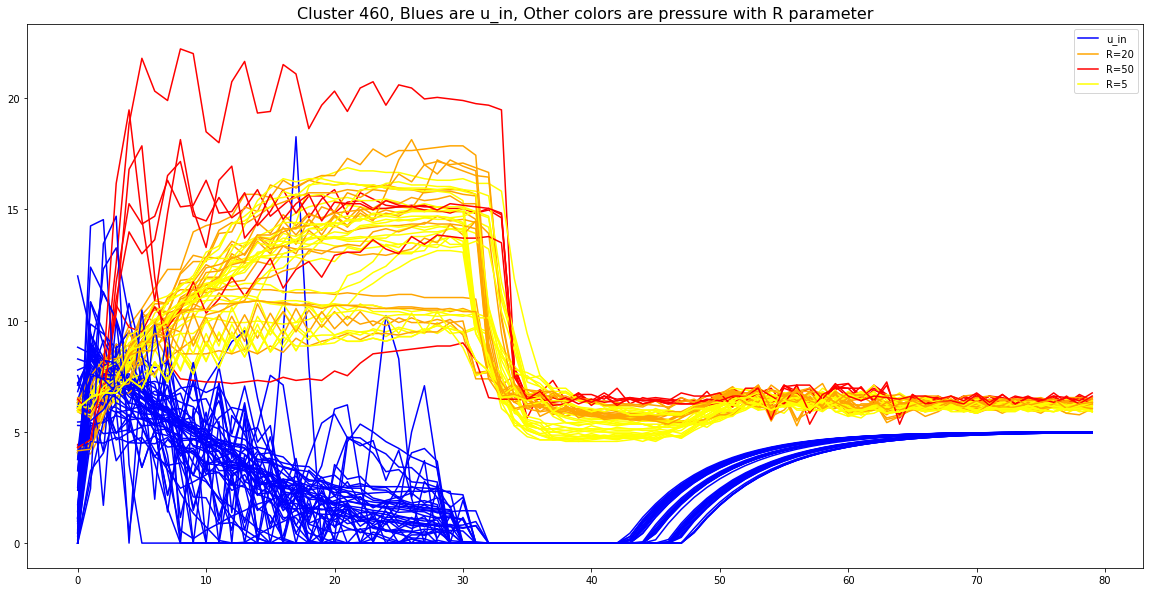

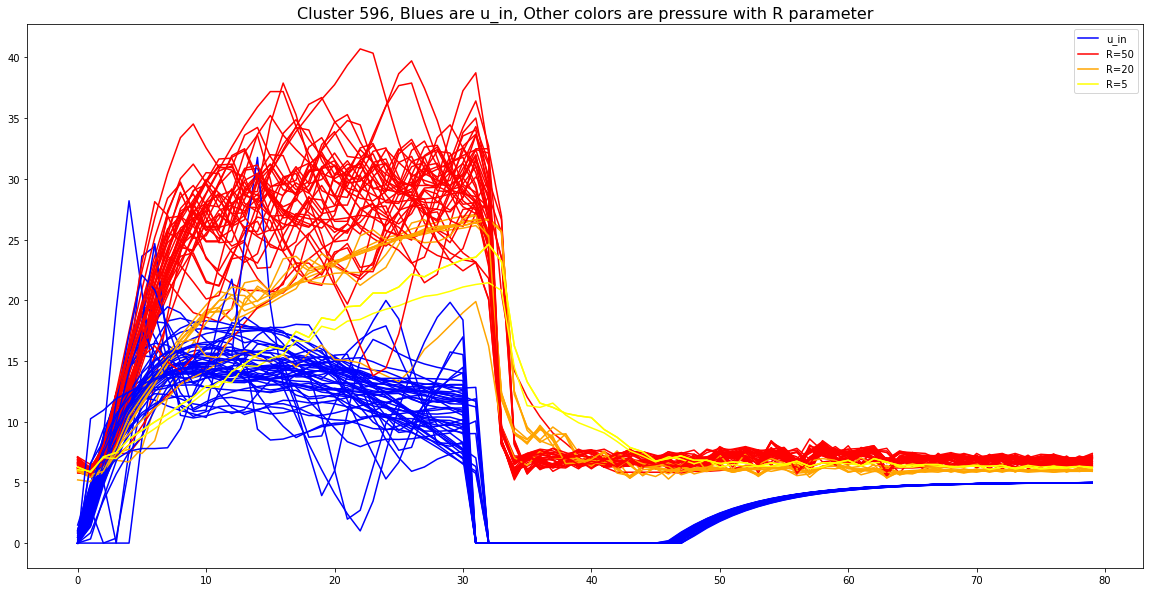

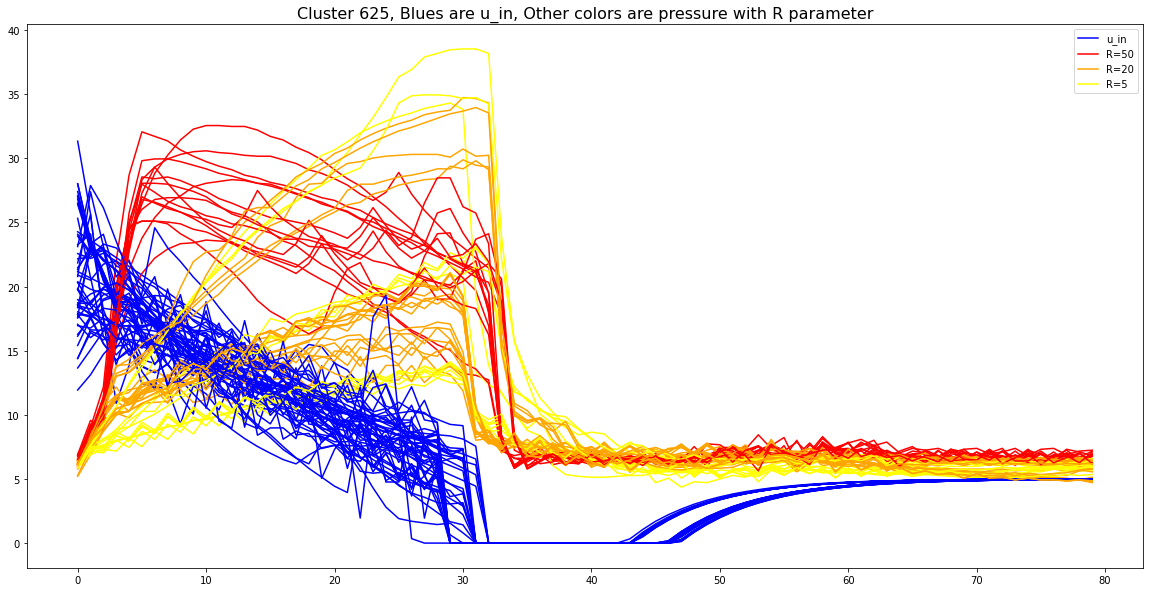

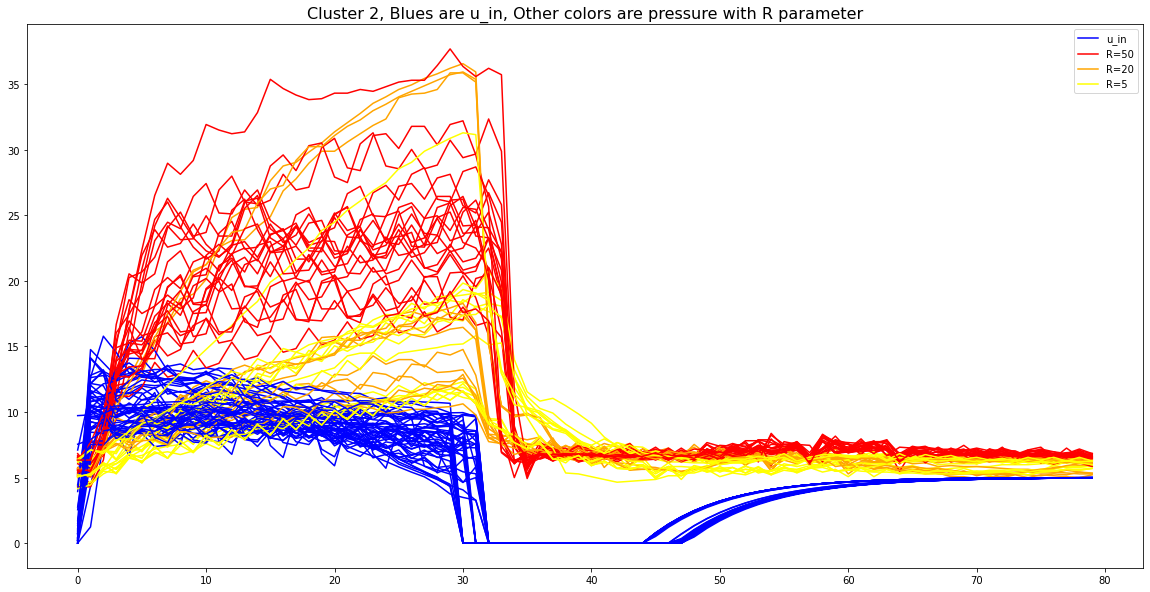

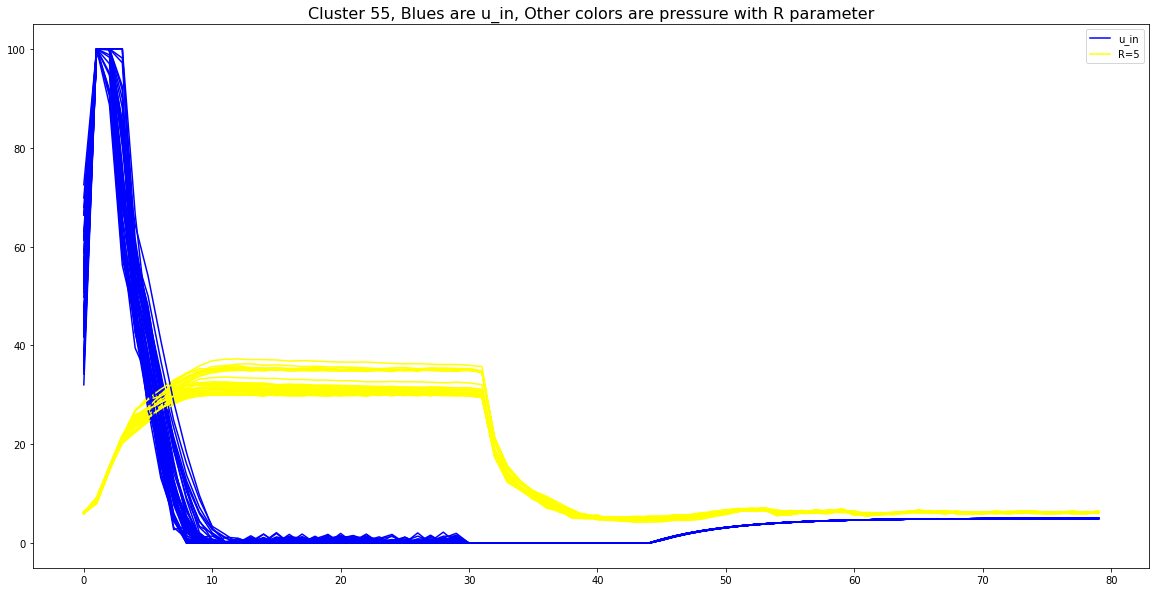

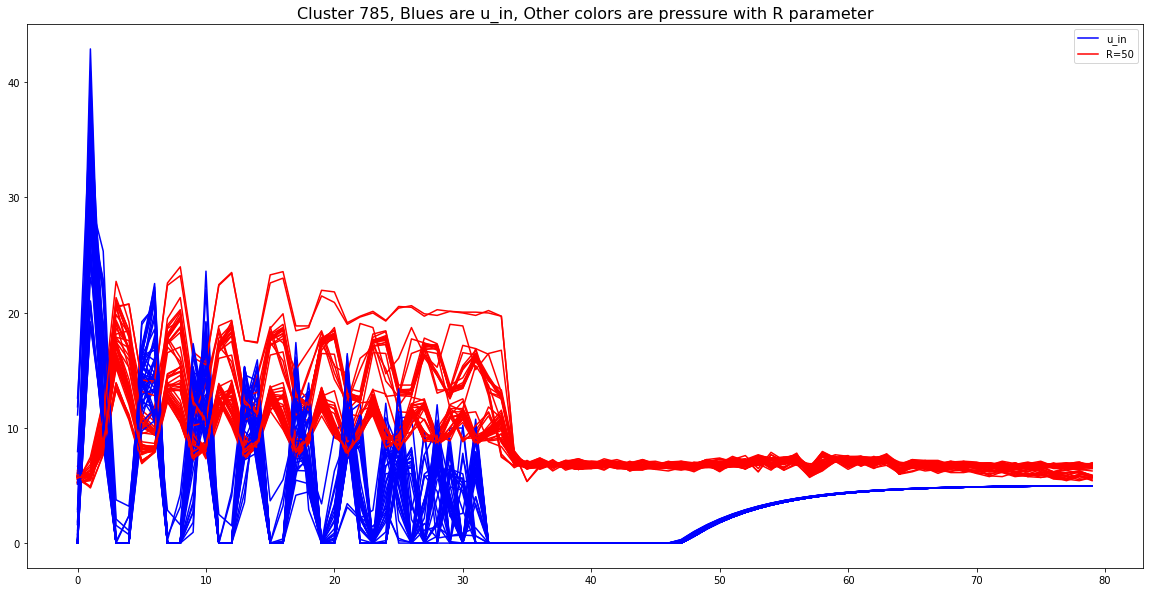

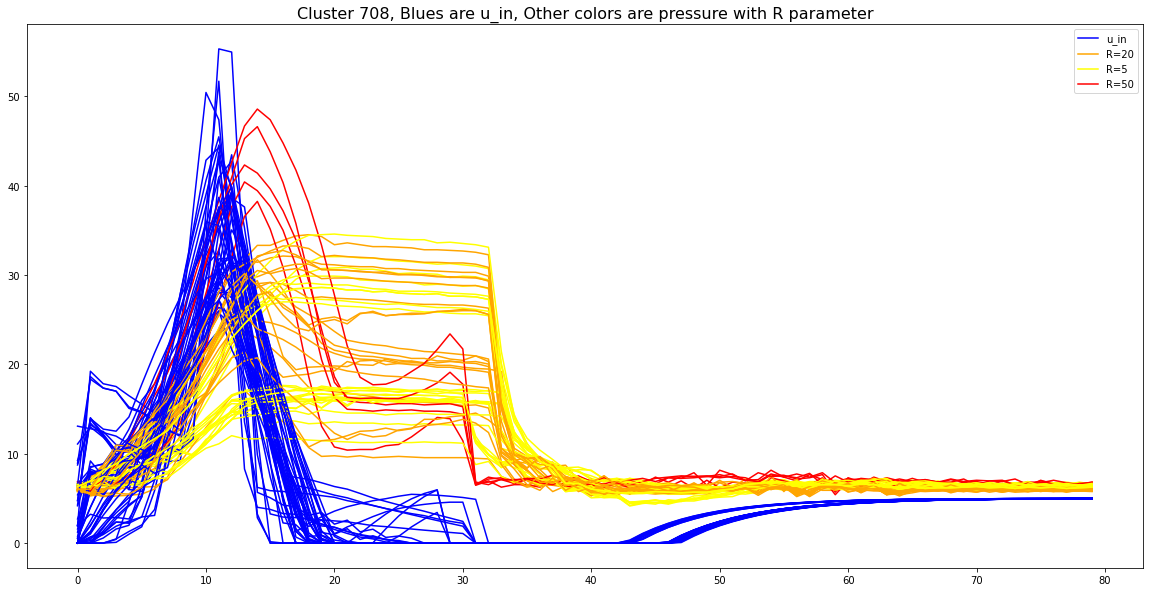

In [5]:
from cuml.cluster import KMeans

model = KMeans(n_clusters=1000)
model.fit(series.iloc[:,IGNORE+SKIP:IGNORE+TIME_STEPS+SKIP])
series['cluster'] = model.labels_
idx = series.cluster.value_counts().index.values

SHOW = 50
DISPLAY = 32
SHOW_R = False
SHOW_C = True

for i in range(DISPLAY):
    
    if i>=DISPLAY//2:
        SHOW_R = True
        SHOW_C = False
        
    k = idx[ np.random.randint(0,300) ]
    temp2 = series.loc[series.cluster==k.item()].sample(SHOW).reset_index(drop=True)
    
    if SHOW_R:
        cdict = {5: 'yellow', 20: 'orange', 50: 'red'}
        plt.figure(figsize=(20,10))
        legend = {5:0, 20:0, 50:0}
        for r in range(SHOW):
            if r!=0: plt.plot(np.arange(80), temp2.iloc[r,IGNORE:IGNORE+80].to_array(), color='blue')
            else: plt.plot(np.arange(80), temp2.iloc[r,IGNORE:IGNORE+80].to_array(), color='blue', label='u_in')
            if legend[temp2.loc[r,'R']]==0:
                legend[temp2.loc[r,'R']]=1; cc = temp2.loc[r,'R']
                plt.plot(np.arange(80), temp2.iloc[r,IGNORE+80:IGNORE+160].to_array(), 
                     c=cdict[temp2.loc[r,'R']], label=f'R={cc}')
            else: plt.plot(np.arange(80), temp2.iloc[r,IGNORE+80:IGNORE+160].to_array(), c=cdict[temp2.loc[r,'R']])
        else: plt.plot(np.arange(80), temp2.iloc[r,IGNORE+80:IGNORE+160].to_array(), c=cdict[temp2.loc[r,'R']])
        y_max = plt.ylim()[1]
        if TIME_STEPS!=80: plt.plot([SKIP+TIME_STEPS-1,SKIP+TIME_STEPS-1],[0,y_max],'--',color='black')
        if SKIP!=0: plt.plot([SKIP-1,SKIP-1],[0,y_max],'--',color='black')
        plt.title(f'Cluster {k.item()}, Blues are u_in, Other colors are pressure with R parameter',size=16)
        plt.legend()
        plt.show()
    
    if SHOW_C:
        cdict = {10: 'red', 20: 'orange', 50: 'yellow'}
        plt.figure(figsize=(20,10))
        legend = {10:0, 20:0, 50:0}
        for r in range(SHOW):
            if r!=0: plt.plot(np.arange(80), temp2.iloc[r,IGNORE:IGNORE+80].to_array(), color='blue')
            else: plt.plot(np.arange(80), temp2.iloc[r,IGNORE:IGNORE+80].to_array(), color='blue', label='u_in')
            if legend[temp2.loc[r,'C']]==0:
                legend[temp2.loc[r,'C']]=1; cc = temp2.loc[r,'C']
                plt.plot(np.arange(80), temp2.iloc[r,IGNORE+80:IGNORE+160].to_array(), 
                     c=cdict[temp2.loc[r,'C']], label=f'C={cc}')
            else: plt.plot(np.arange(80), temp2.iloc[r,IGNORE+80:IGNORE+160].to_array(), c=cdict[temp2.loc[r,'C']])
        y_max = plt.ylim()[1]
        if TIME_STEPS!=80: plt.plot([SKIP+TIME_STEPS-1,SKIP+TIME_STEPS-1],[0,y_max],'--',color='black')
        if SKIP!=0: plt.plot([SKIP-1,SKIP-1],[0,y_max],'--',color='black')
        plt.title(f'Cluster {k.item()}, Blues are u_in, Others colors are pressure with C parameter',size=16)
        plt.legend()
        plt.show()

# RAPIDS KNN Model
Since many `u_in` patterns repeat themselves in the competition data, we should be able to achieve a good score using RAPIDS KNN. Let't now build a RAPIDS KNN model to infer test dataset and submit to LB!

In [6]:
# LOAD TEST
test = cudf.read_csv('../input/ventilator-pressure-prediction/test.csv')
exhale = 80-test.groupby('breath_id')[['u_out']].agg('sum')
length = test.groupby('breath_id')[['time_step']].agg('max')
first_id = test.groupby('breath_id')[['id']].agg('min')
print('Test shape:',test.shape)
test.head()

Test shape: (4024000, 7)


id  breath_id  R   C  time_step       u_in  u_out
0   1          0  5  20   0.000000   0.000000      0
1   2          0  5  20   0.031904   7.515046      0
2   3          0  5  20   0.063827  14.651675      0
3   4          0  5  20   0.095751  21.230610      0
4   5          0  5  20   0.127644  26.320956      0

In [7]:
# CONVERT TEST TO SERIES
test_series = test.groupby('breath_id').collect().reset_index()
for k in range(80): test_series[f'x_{k}'] = test_series.u_in.list.get(k)
for k in range(80): test_series[f'z_{k}'] = 1-test_series.u_out.list.get(k)
test_series.R = test_series.R.list.get(0)
test_series.C = test_series.C.list.get(0)
test_series = test_series.drop(['id','time_step','u_in','u_out'],axis=1)
test_series = test_series.merge(exhale,on='breath_id',how='left')
test_series = test_series.merge(length,on='breath_id',how='left')
test_series = test_series.merge(first_id,on='breath_id',how='left')
test_series = test_series.sort_values('breath_id').reset_index(drop=True)
test_series = test_series.rename({'time_step':'time_length','u_out':'expire','id':'first_id'},axis=1)

print('Test as series shape:', test_series.shape )
print('Min inhale length=', test_series['expire'].min(),',Max inhale length=', test_series['expire'].max(),
      'Max breath length=',test_series['time_length'].max() )
test_series.head()

Test as series shape: (50300, 166)
Min inhale length= 25 ,Max inhale length= 32 Max breath length= 2.9352025985717773


breath_id   R   C         x_0        x_1        x_2        x_3        x_4  \
0          0   5  20    0.000000   7.515046  14.651675  21.230610  26.320956   
1          8   5  50   16.140384  11.429617  13.755544   9.306066  12.743169   
2         11  50  10   33.717608  26.595397  20.281570  13.548649   6.483971   
3         24  50  10    1.203812   3.150063   4.900224   6.484965   7.846378   
4         31  20  50  100.000000  58.192753  12.083520  13.780551  48.687221   

         x_5        x_6  ...  z_73  z_74  z_75  z_76  z_77  z_78  z_79  \
0  30.486938  33.545950  ...     0     0     0     0     0     0     0   
1   7.150991  11.984329  ...     0     0     0     0     0     0     0   
2   1.112624   1.551207  ...     0     0     0     0     0     0     0   
3   9.015769  10.016142  ...     0     0     0     0     0     0     0   
4  23.392914   5.957594  ...     0     0     0     0     0     0     0   

   expire  time_length  first_id  
0      31     2.519844         1  
1      29     2.689998        81  
2      29     2.722669       161  
3      30     2.675477       241  
4      29     2.688264       321  

[5 rows x 166 columns]

# Fit Train. Infer OOF and Test
We will now train RAPIDS KNN model with train data and infer test data. We will build 9 models. One for each combination of `R` and `C`. For each model, we will compute the error for each time step position and plot the result. Therefore we will see if predicting pressure at time step 0 is better or worse than say predicted pressure at time step 20. We will also see which combinations of `R` and `C` are the most difficult to predict.

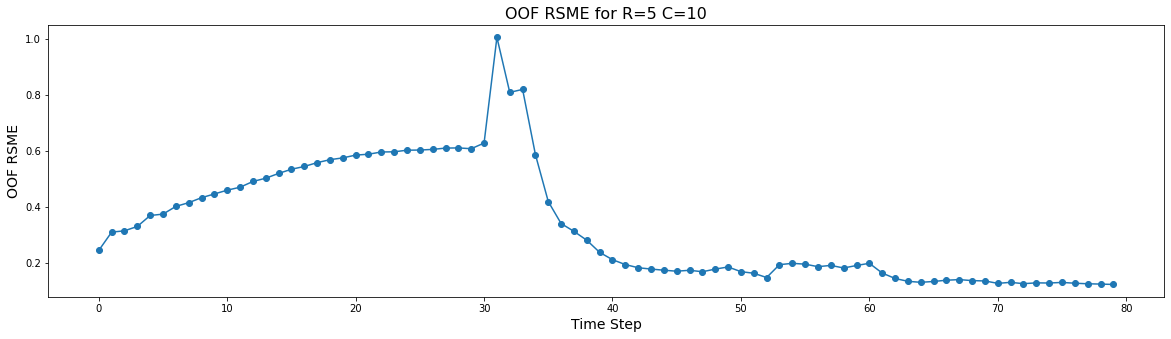

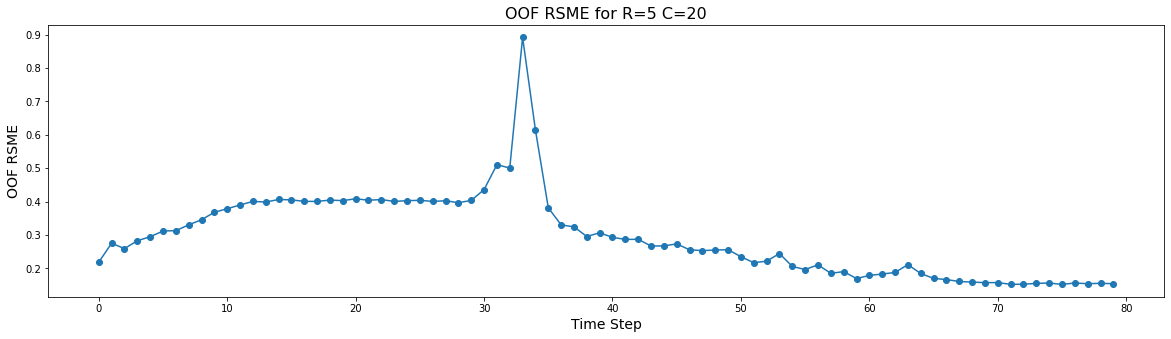

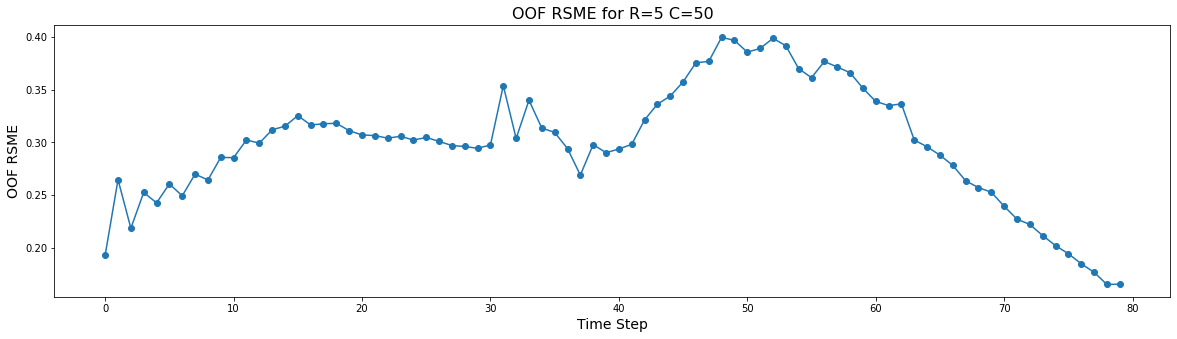

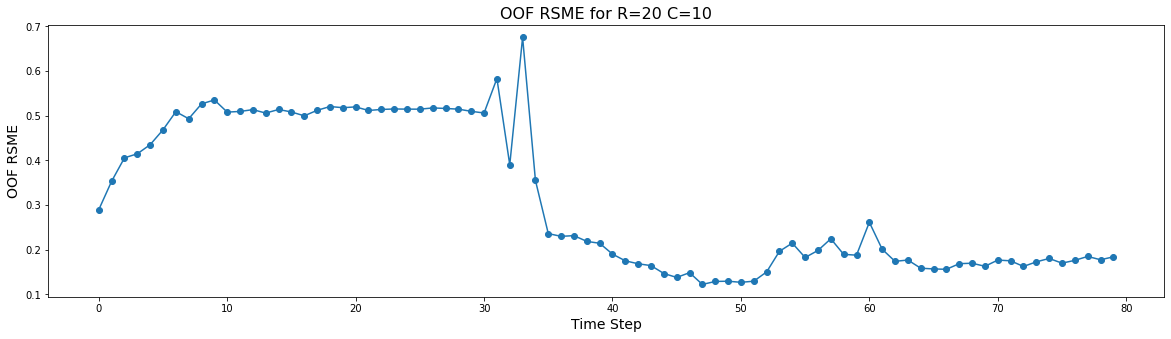

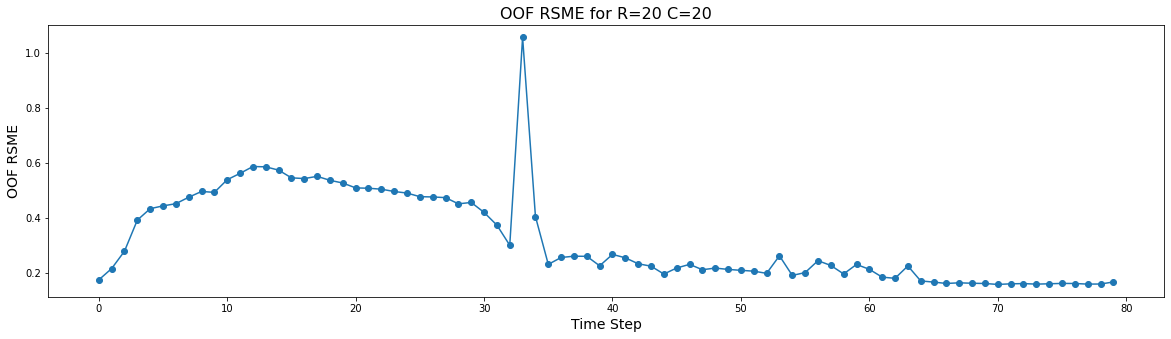

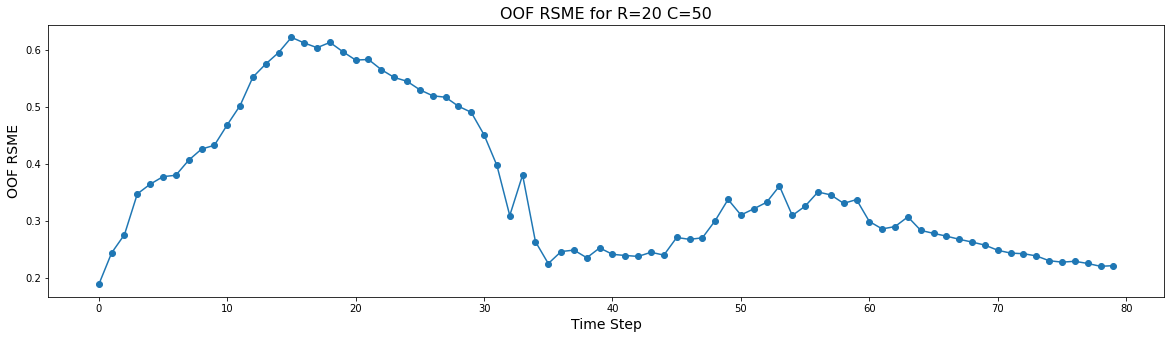

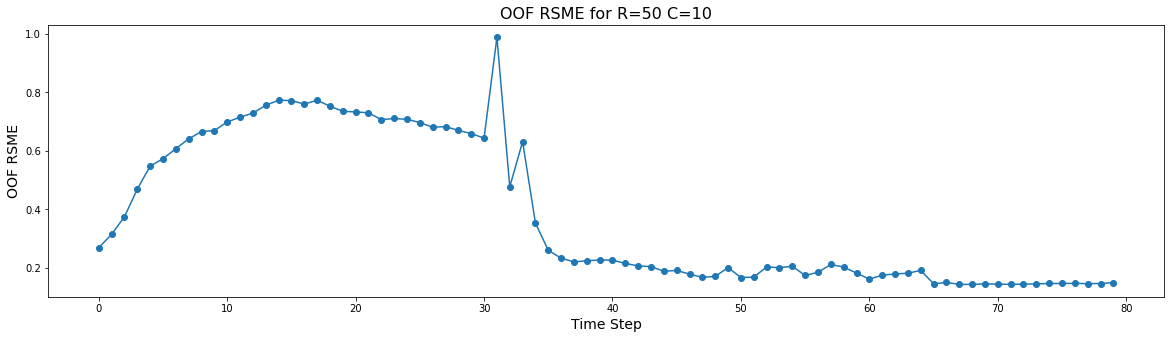

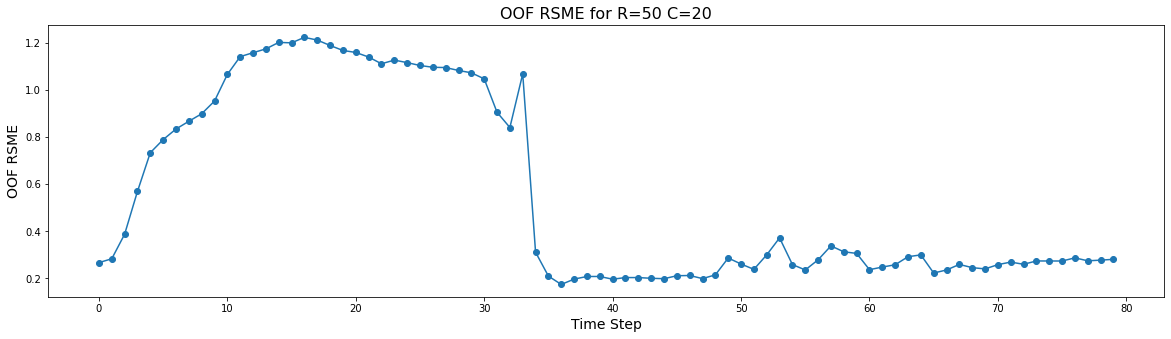

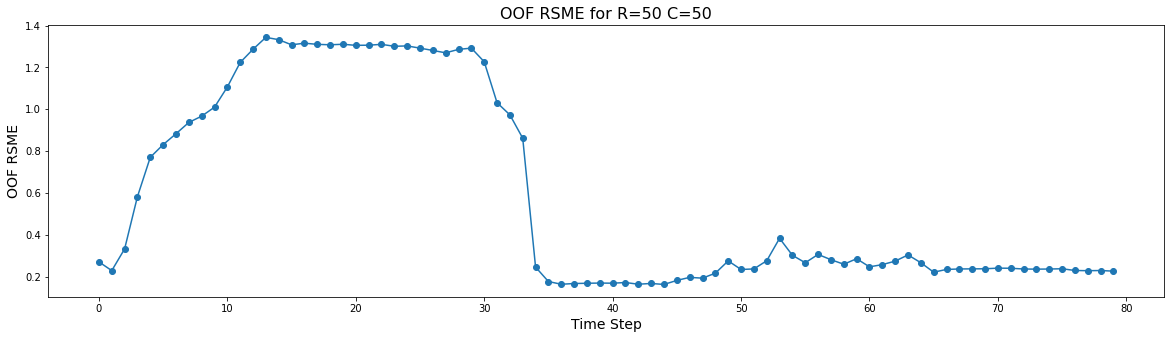

In [8]:
from cuml.neighbors import NearestNeighbors 
NEIGHBORS = 2
SIZE = 80

# OOF
all_true = []
all_oof = []
all_true_inhale = []
all_oof_inhale = []

# TEST PREDS
all_pred = []
all_test_id = []

for r in [5,20,50]:
    for c in [10,20,50]:
        
        # FIT TRAIN KNN
        temp2 = series.loc[(series.R==r)&(series.C==c)].reset_index(drop=True)
        model = NearestNeighbors(n_neighbors=NEIGHBORS, metric='l1')
        model.fit(temp2.iloc[:,IGNORE:SIZE+IGNORE])

        # INFER OOF
        err = []
        distances, indices = model.kneighbors(temp2.iloc[:,IGNORE:IGNORE+SIZE])
        
        # INFER TEST
        test_temp2 = test_series.loc[(test_series.R==r)&(test_series.C==c)].reset_index(drop=True)
        test_distances, test_indices = model.kneighbors(test_temp2.iloc[:,IGNORE:IGNORE+SIZE])
        
        for DO in range(80):
            
            # OOF AND COLLECT TRUE (BELOW WE USE COLUMN 1 NOT 0 TO AVOID USING ITSELF)
            oof = temp2.loc[indices.iloc[:,1].values,f'y_{DO}'].values
            true = temp2[f'y_{DO}'].values
            mask = temp2[f'z_{DO}'].values
            
            # TEST PREDS (BELOW WE USE COLUMN 0 NOT 1, BECAUSE THERE IS NO ITSELF)
            preds = temp2.loc[test_indices.iloc[:,0].values,f'y_{DO}'].values
            test_ids = test_temp2.first_id.values+DO

            # RECORD OOF ERROR FOR PLOT
            mae = cupy.mean(cupy.abs( true-oof ))
            err.append(mae)
            
            # RECORD OOF
            idx = cupy.where( mask==1 )[0]
            all_true_inhale.append( true[idx] )
            all_oof_inhale.append( oof[idx] )
            all_true.append( true )
            all_oof.append( oof )
            
            # RECORD TEST PREDS
            all_pred.append( preds )
            all_test_id.append( test_ids )
            
        # PLOT OOF ERROR
        plt.figure(figsize=(20,5))
        plt.plot(np.arange(80),err,'-o')
        plt.ylabel('OOF RSME',size=14)
        plt.xlabel('Time Step',size=14)
        plt.title(f'OOF RSME for R={r} C={c}',size=16)
        plt.show()

In [9]:
# COMPUTE OOF SCORE FOR INHALE ONLY
all_true2 = cupy.concatenate(all_true_inhale)
all_oof2 = cupy.concatenate(all_oof_inhale)
rsme = cupy.mean(cupy.abs( all_true2-all_oof2 ))
print('RAPIDS KNN CV RSME=',rsme, '(inhale only)')

# COMPUTE OOF SCORE FOR ALL 80 TIME STEPS
all_true2 = cupy.concatenate(all_true)
all_oof2 = cupy.concatenate(all_oof)
rsme = cupy.mean(cupy.abs( all_true2-all_oof2 ))
print('RAPIDS KNN CV RSME=',rsme, '(all breath)')

RAPIDS KNN CV RSME= 0.6049366853331428 (inhale only)
RAPIDS KNN CV RSME= 0.3881837901832737 (all breath)


# Write Submission CSV

In [10]:
sub = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')
sub['id'] = cupy.asnumpy( cupy.hstack(all_test_id) )
sub['pressure'] = cupy.asnumpy( cupy.hstack(all_pred) )
sub = sub.sort_values('id').reset_index(drop=True)
sub.to_csv('submission_rapids_knn.csv',index=False)
print( sub.shape )
sub.head()

(4024000, 2)


id  pressure
0   1  6.259305
1   2  5.767190
2   3  7.243535
3   4  7.735650
4   5  9.211995